<a href="https://colab.research.google.com/github/AnastasiaBrinati/experiments/blob/main/Endpoints300s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **PROVA MODELLI CENTRALIZZATI PREDIZIONE INVOCATIONS' RATE**



#### Imports

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping

!pip install -q -U keras-tuner
import keras_tuner as kt

# Use seaborn for pairplot.
!pip install datasets

from datasets import load_dataset

# Data

In [44]:
dataset_e1 = load_dataset("anastasiafrosted/endpoint0_300", download_mode="force_redownload")
dataset_e2 = load_dataset("anastasiafrosted/endpoint1_300", download_mode="force_redownload")

df_1 = pd.DataFrame(dataset_e1['train'])
df_2 = pd.DataFrame(dataset_e2['train'])

# Ensure the `timestamp` column is in datetime format
df_1['timestamp'] = pd.to_datetime(df_1['timestamp'])
df_2['timestamp'] = pd.to_datetime(df_2['timestamp'])

train-00000-of-00001.parquet:   0%|          | 0.00/629k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25600 [00:00<?, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/327k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/22019 [00:00<?, ? examples/s]

In [45]:
data1 = df_1
data1 = data1.set_index("timestamp")
data2 = df_2
data2 = data2.set_index("timestamp")
freq='300s'

In [46]:
origin = "2023-06-15"
start = "2023-07-02" # origin + prediction_lenght
end = "2023-07-08"

train_data1 = data1["2022-12-20":origin]
valid_data1 = data1[origin:start]
test_data1 = data1[start:]

train_data2 = data2["2022-12-20":origin]
valid_data2 = data2[origin:start]
test_data2 = data2[start:]

# List of columns to drop
columns_to_drop = [
    'e_type_LSFProvider', 'e_type_CobaltProvider',
    'e_type_PBSProProvider', 'e_type_LocalProvider',
    'e_type_KubernetesProvider', 'e_type_SlurmProvider'
]
train_data1 = train_data1.drop(columns=columns_to_drop, errors='ignore')
valid_data1 = valid_data1.drop(columns=columns_to_drop, errors='ignore')
test_data1 = test_data1.drop(columns=columns_to_drop, errors='ignore')

train_data2 = train_data2.drop(columns=columns_to_drop, errors='ignore')
valid_data2 = valid_data2.drop(columns=columns_to_drop, errors='ignore')
test_data2 = test_data2.drop(columns=columns_to_drop, errors='ignore')

#### Scaling

In [47]:
from sklearn.preprocessing import StandardScaler

# Crea un'istanza dello scaler
scaler = StandardScaler()

In [182]:
# ENDPOINT 1:

# ZERO-FITTING

# Creare il range completo con frequenza al secondo
start_date = train_data1.index.min()
end_date = train_data1.index.max()
time_period = pd.date_range(start=start_date, end=end_date, freq=freq)
zero_fitted_train1 = train_data1.copy()
zero_fitted_train1 = zero_fitted_train1.reindex(time_period)
zero_fitted_train1 = zero_fitted_train1.fillna(0)
zero_fitted_train1.reset_index(inplace=True)
zero_fitted_train1.rename(columns={'index': 'timestamp'}, inplace=True)
zero_fitted_train1.set_index('timestamp', inplace=True)

# Creare il range completo con frequenza al secondo
start_date = valid_data1.index.min()
end_date = valid_data1.index.max()
time_period = pd.date_range(start=start_date, end=end_date, freq=freq)
zero_fitted_valid1 = valid_data1.copy()
zero_fitted_valid1 = zero_fitted_valid1.reindex(time_period)
zero_fitted_valid1 = zero_fitted_valid1.fillna(0)
zero_fitted_valid1.reset_index(inplace=True)
zero_fitted_valid1.rename(columns={'index': 'timestamp'}, inplace=True)
zero_fitted_valid1.set_index('timestamp', inplace=True)

# Creare il range completo con frequenza al secondo
start_date = test_data1.index.min()
end_date = test_data1.index.max()
time_period = pd.date_range(start=start_date, end=end_date, freq=freq)
zero_fitted_test1 = test_data1.copy()
zero_fitted_test1 = zero_fitted_test1.reindex(time_period)
zero_fitted_test1 = zero_fitted_test1.fillna(0)
zero_fitted_test1.reset_index(inplace=True)
zero_fitted_test1.rename(columns={'index': 'timestamp'}, inplace=True)
zero_fitted_test1.set_index('timestamp', inplace=True)

In [183]:
# ENDPOINT 1:

# SCALING
scaled_train1 = zero_fitted_train1.copy()
scaled_train1[scaled_train1.columns.drop('avg_invocations_rate')] = scaler.fit_transform(
    scaled_train1[scaled_train1.columns.drop('avg_invocations_rate')]
)
train1 = scaled_train1

# Per il dataset di validazione
scaled_valid1 = zero_fitted_valid1.copy()
scaled_valid1[scaled_valid1.columns.drop('avg_invocations_rate')] = scaler.transform(
    scaled_valid1[scaled_valid1.columns.drop('avg_invocations_rate')]
)
valid1 = scaled_valid1

# Per il dataset di test
scaled_test1 = zero_fitted_test1.copy()
scaled_test1[scaled_test1.columns.drop('avg_invocations_rate')] = scaler.transform(
    zero_fitted_test1[zero_fitted_test1.columns.drop('avg_invocations_rate')]
)
test1 = scaled_test1

In [184]:
# ENDPOINT 2:

# ZERO-FITTING

# Creare il range completo con frequenza al secondo
start_date = train_data2.index.min()
end_date = train_data2.index.max()
time_period = pd.date_range(start=start_date, end=end_date, freq=freq)
zero_fitted_train2 = train_data2.copy()
zero_fitted_train2 = zero_fitted_train2.reindex(time_period)
zero_fitted_train2 = zero_fitted_train2.fillna(0)
zero_fitted_train2.reset_index(inplace=True)
zero_fitted_train2.rename(columns={'index': 'timestamp'}, inplace=True)
zero_fitted_train2.set_index('timestamp', inplace=True)

# Creare il range completo con frequenza al secondo
start_date = valid_data2.index.min()
end_date = valid_data2.index.max()
time_period = pd.date_range(start=start_date, end=end_date, freq=freq)
zero_fitted_valid2 = valid_data2.copy()
zero_fitted_valid2 = zero_fitted_valid2.reindex(time_period)
zero_fitted_valid2 = zero_fitted_valid2.fillna(0)
zero_fitted_valid2.reset_index(inplace=True)
zero_fitted_valid2.rename(columns={'index': 'timestamp'}, inplace=True)
zero_fitted_valid2.set_index('timestamp', inplace=True)

# Creare il range completo con frequenza al secondo
start_date = test_data2.index.min()
end_date = test_data2.index.max()
time_period = pd.date_range(start=start_date, end=end_date, freq=freq)
zero_fitted_test2 = test_data2.copy()
zero_fitted_test2 = zero_fitted_test2.reindex(time_period)
zero_fitted_test2 = zero_fitted_test2.fillna(0)
zero_fitted_test2.reset_index(inplace=True)
zero_fitted_test2.rename(columns={'index': 'timestamp'}, inplace=True)
zero_fitted_test2.set_index('timestamp', inplace=True)

In [185]:
# ENDPOINT 2:

# SCALING
scaled_train2 = zero_fitted_train2.copy()
scaled_train2[scaled_train2.columns.drop('avg_invocations_rate')] = scaler.fit_transform(
    scaled_train2[scaled_train2.columns.drop('avg_invocations_rate')]
)
train2 = scaled_train2

# Per il dataset di validazione
scaled_valid2 = zero_fitted_valid2.copy()
scaled_valid2[scaled_valid2.columns.drop('avg_invocations_rate')] = scaler.transform(
    scaled_valid2[scaled_valid2.columns.drop('avg_invocations_rate')]
)
valid2 = scaled_valid2

# Per il dataset di test
scaled_test2 = zero_fitted_test2.copy()
scaled_test2[scaled_test2.columns.drop('avg_invocations_rate')] = scaler.transform(
    zero_fitted_test2[zero_fitted_test2.columns.drop('avg_invocations_rate')]
)
test2 = scaled_test2

#### Config (Parameters)

In [137]:
batch_size = 32
num_features = 6
sequence_lenght = 7
prediction_lenght = 7

seed = 123
neurons = 32
epochs = 10

# Models

## Forecasting one-step-ahead

In [138]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate=0.01, epochs=epochs):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=10, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs, callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

### Univariate series

In [186]:
tr1 = train1['avg_invocations_rate']
vl1 = valid1['avg_invocations_rate']
ts1 = test1['avg_invocations_rate']

tr2 = train2['avg_invocations_rate']
vl2 = valid2['avg_invocations_rate']
ts2 = test2['avg_invocations_rate']

In [187]:
# ENDPOINT 1:
tf.random.set_seed(seed)  # extra code – ensures reproducibility
train_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    tr1.to_numpy(),
    targets=tr1[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)
valid_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    vl1.to_numpy(),
    targets=vl1[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)
test_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    ts1.to_numpy(),
    targets=ts1[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)

In [188]:
# ENDPOINT 2:
tf.random.set_seed(seed)  # extra code – ensures reproducibility
train_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    tr2.to_numpy(),
    targets=tr2[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)
valid_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    vl2.to_numpy(),
    targets=vl2[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)
test_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    ts2.to_numpy(),
    targets=ts2[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)

#### Linear Model

In [168]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[sequence_lenght])
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [189]:
fit_and_evaluate(model, train_ds1, valid_ds1)

Epoch 1/10
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 1.9821e-04 - mae: 0.0113 - val_loss: 1.6532e-04 - val_mae: 0.0105
Epoch 2/10
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 1.9669e-04 - mae: 0.0112 - val_loss: 1.6275e-04 - val_mae: 0.0104
Epoch 3/10
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 1.9420e-04 - mae: 0.0112 - val_loss: 1.6037e-04 - val_mae: 0.0104
Epoch 4/10
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 1.9233e-04 - mae: 0.0111 - val_loss: 1.5823e-04 - val_mae: 0.0103
Epoch 5/10
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 1.9060e-04 - mae: 0.0111 - val_loss: 1.5647e-04 - val_mae: 0.0099
Epoch 6/10
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 1.8928e-04 - mae: 0.0110 - val_loss: 1.5460e-04 - val_mae: 0.0099
Epoch 7/10
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 1.8779e-04 - mae: 0.0109 - val_loss: 1.5318e-04 - val_mae: 0.0097
Epoch 8/10
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 1.8581e-04 - mae: 0.0108 - val_loss: 1.512

9667.509235441685

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


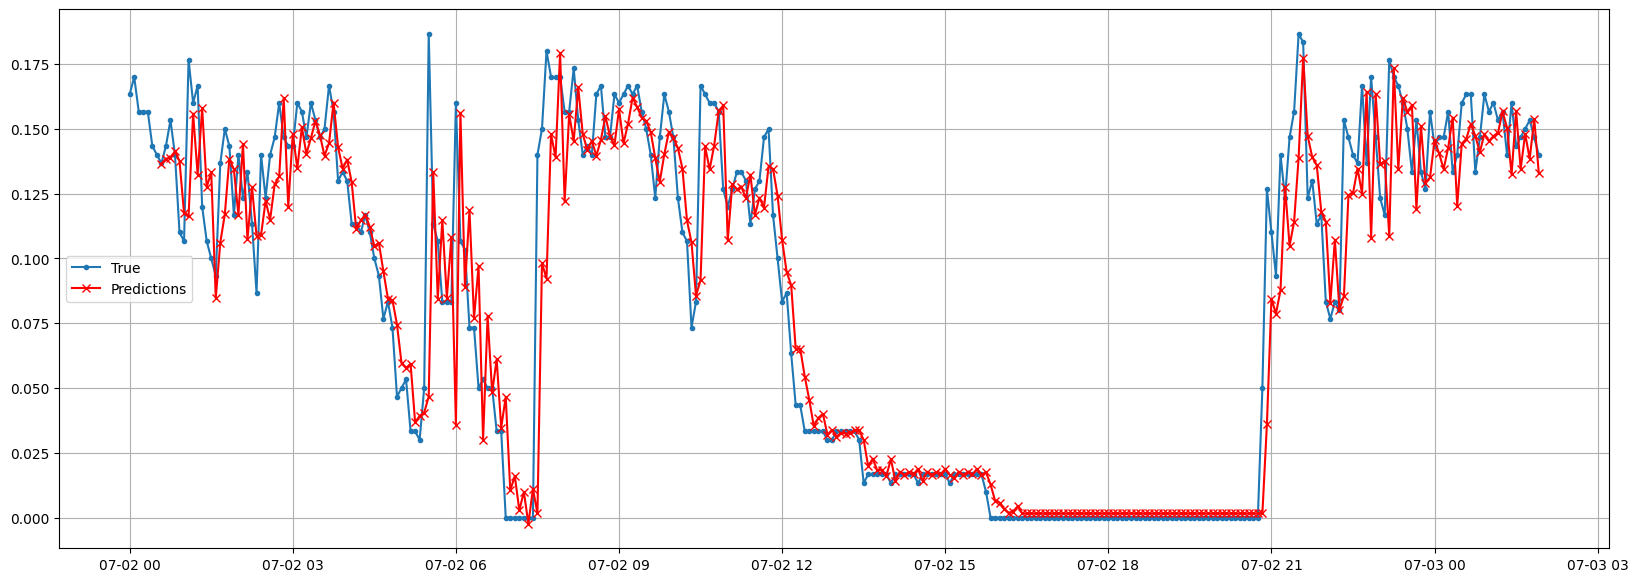

In [190]:
Y_pred = model.predict(test_ds1)
Y_pred = pd.Series(Y_pred.flatten(), index=test1.index[sequence_lenght:])

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test1['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

In [191]:
fit_and_evaluate(model, train_ds2, valid_ds2)

Epoch 1/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 1.1450e-04 - mae: 0.0040 - val_loss: 1.7542e-05 - val_mae: 0.0036
Epoch 2/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 1.1403e-04 - mae: 0.0042 - val_loss: 1.9059e-05 - val_mae: 0.0039
Epoch 3/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 1.1074e-04 - mae: 0.0043 - val_loss: 2.1338e-05 - val_mae: 0.0040
Epoch 4/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 1.1024e-04 - mae: 0.0044 - val_loss: 2.1614e-05 - val_mae: 0.0042
Epoch 5/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 1.0788e-04 - mae: 0.0044 - val_loss: 2.2781e-05 - val_mae: 0.0043
Epoch 6/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 1.0875e-04 - mae: 0.0044 - val_loss: 2.3056e-05 - val_mae: 0.0043
Epoch 7/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 1.0758e-04 - mae: 0.0045 - val_loss: 2.3761e-05 - val_mae: 0.0044
Epoch 8/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 1.0678e-04 - mae: 0.0045 - val_loss: 2.3

3554.98562566936

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


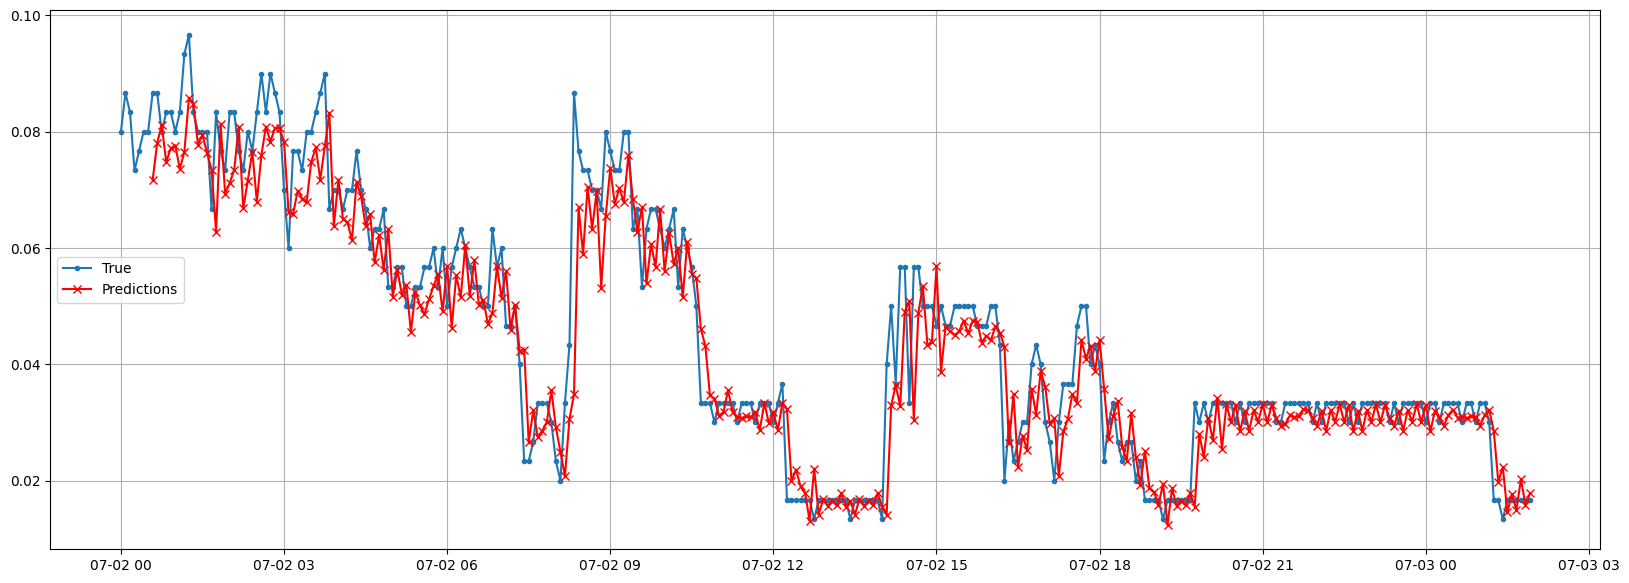

In [192]:
Y_pred = model.predict(test_ds2)
Y_pred = pd.Series(Y_pred.flatten(), index=test2.index[sequence_lenght:])

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test2['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

#### Simple RNN

Recall that the input_shape argument ignores
the first dimension (i.e., the batch size), and since recurrent layers can accept
input sequences of any length, we can set the second dimension to None, which
means “any size”. Lastly, since we’re dealing with a univariate time series, we
need the last dimension’s size to be 1. This is why we specified the input shape
* [None, 1] : it means “univariate sequences of any length”.


In [60]:
univar_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(neurons*2, input_shape=[None, 1]),
  tf.keras.layers.Dense(1) # no activation function by default
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [193]:
fit_and_evaluate(univar_model, train_ds1, valid_ds1)

Epoch 1/10
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 1.6882e-04 - mae: 0.0108 - val_loss: 1.3479e-04 - val_mae: 0.0107
Epoch 2/10
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 1.6475e-04 - mae: 0.0103 - val_loss: 1.2817e-04 - val_mae: 0.0094
Epoch 3/10
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 1.6461e-04 - mae: 0.0103 - val_loss: 1.2682e-04 - val_mae: 0.0080
Epoch 4/10
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 1.6301e-04 - mae: 0.0102 - val_loss: 1.2612e-04 - val_mae: 0.0093
Epoch 5/10
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 1.6436e-04 - mae: 0.0103 - val_loss: 1.2471e-04 - val_mae: 0.0082
Epoch 6/10
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 1.6232e-04 - mae: 0.0102 - val_loss: 1.2396e-04 - val_mae: 0.0085
Epoch 7/10
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1.6291e-04 - mae: 0.0101 - val_loss: 1.2470e-04 - val_mae: 0.0092
Epoch 8/10
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 1.6200e-04 - mae: 0.0100 - val_loss:

7942.716591060162

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


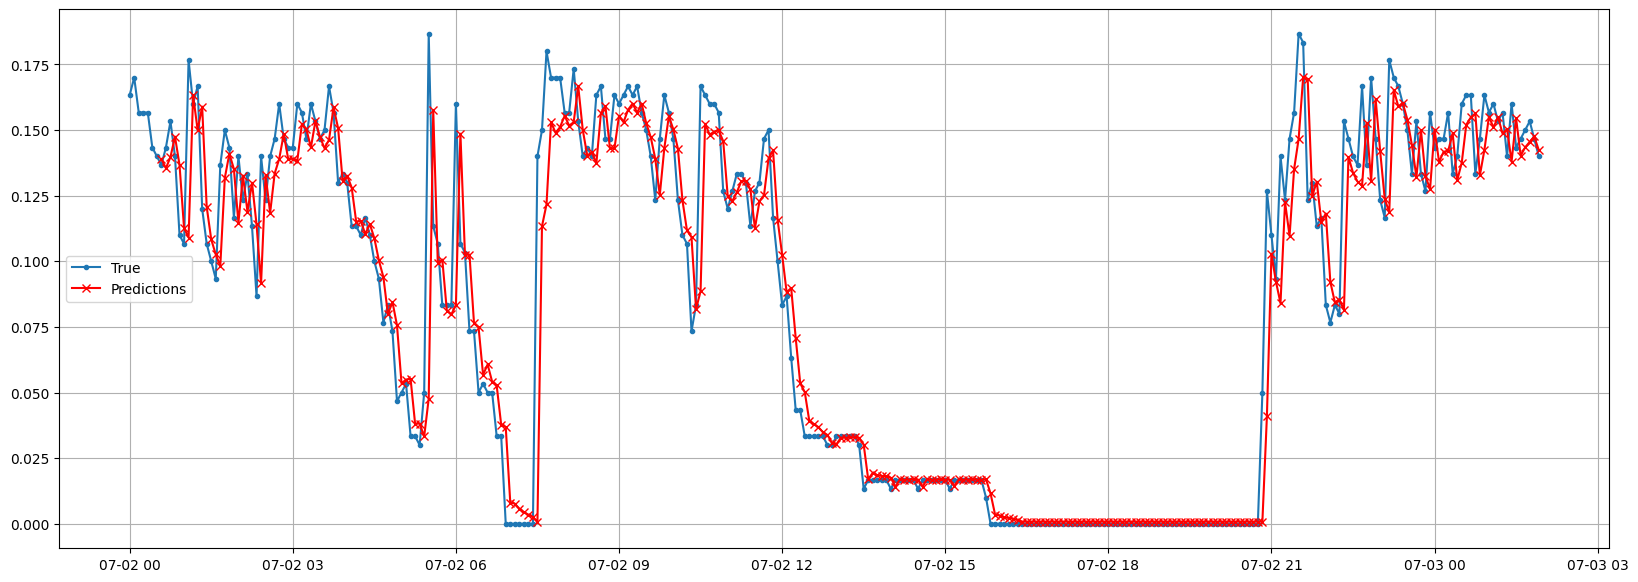

In [194]:
Y_pred = univar_model.predict(test_ds1)
Y_pred = pd.Series(Y_pred.flatten(), index=ts1.index[sequence_lenght:])

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test1['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

In [195]:
fit_and_evaluate(univar_model, train_ds2, valid_ds2)

Epoch 1/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 9.5406e-05 - mae: 0.0041 - val_loss: 2.3478e-05 - val_mae: 0.0049
Epoch 2/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 9.5534e-05 - mae: 0.0044 - val_loss: 2.5053e-05 - val_mae: 0.0048
Epoch 3/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 9.2879e-05 - mae: 0.0043 - val_loss: 2.4468e-05 - val_mae: 0.0049
Epoch 4/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 9.3005e-05 - mae: 0.0043 - val_loss: 2.3540e-05 - val_mae: 0.0051
Epoch 5/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 9.2462e-05 - mae: 0.0043 - val_loss: 2.7582e-05 - val_mae: 0.0048
Epoch 6/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 9.2280e-05 - mae: 0.0044 - val_loss: 2.4132e-05 - val_mae: 0.0049
Epoch 7/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 9.2146e-05 - mae: 0.0043 - val_loss: 4.1839e-05 - val_mae: 0.0064
Epoch 8/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 9.2521e-05 - mae: 0.0043 - val_loss: 

4678.882192820311

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


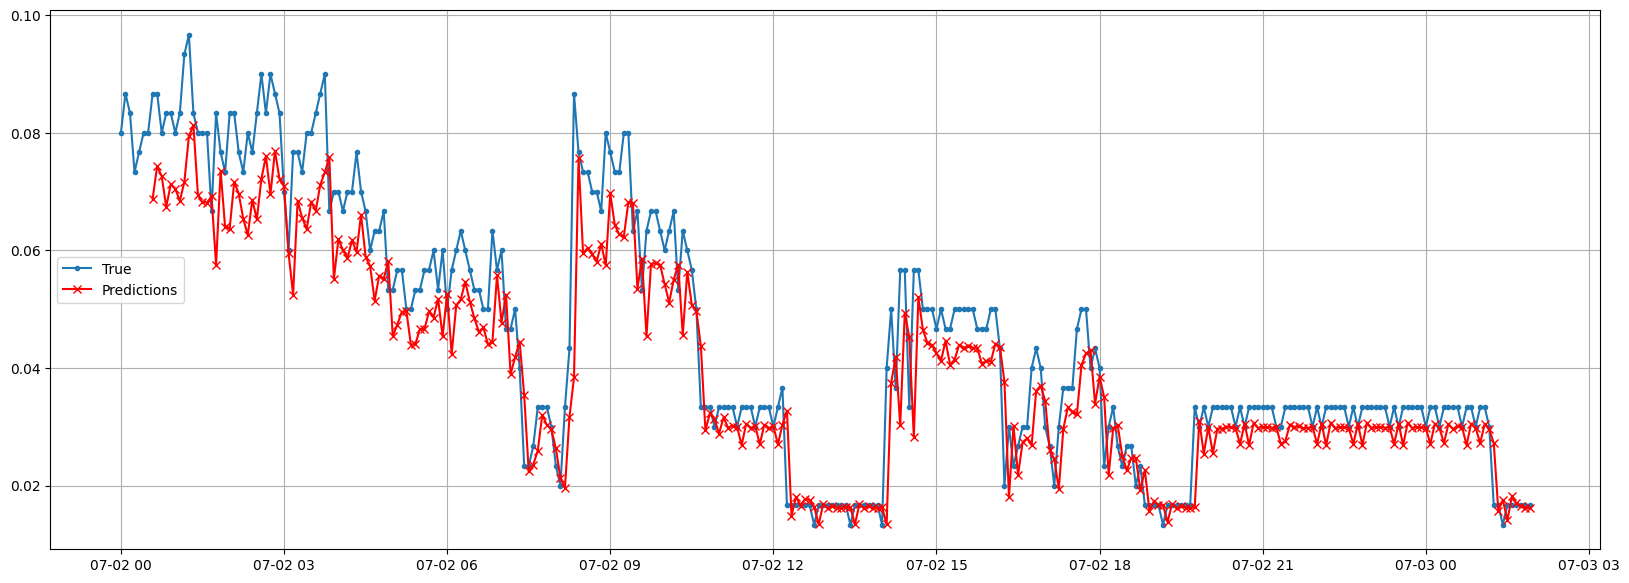

In [196]:
Y_pred = univar_model.predict(test_ds2)
Y_pred = pd.Series(Y_pred.flatten(), index=ts2.index[sequence_lenght:])

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test2['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

#### Deep RNN

In [65]:
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(neurons*3, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(neurons*2, return_sequences=True),
    tf.keras.layers.SimpleRNN(neurons),
    tf.keras.layers.Dense(1)
])

In [197]:
fit_and_evaluate(deep_model, train_ds1, valid_ds1)

Epoch 1/10
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 1.7339e-04 - mae: 0.0112 - val_loss: 1.3909e-04 - val_mae: 0.0116
Epoch 2/10
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - loss: 1.7191e-04 - mae: 0.0114 - val_loss: 1.2545e-04 - val_mae: 0.0092
Epoch 3/10
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 1.6793e-04 - mae: 0.0108 - val_loss: 1.2724e-04 - val_mae: 0.0080
Epoch 4/10
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - loss: 1.6782e-04 - mae: 0.0108 - val_loss: 1.2733e-04 - val_mae: 0.0081
Epoch 5/10
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 1.6689e-04 - mae: 0.0108 - val_loss: 1.3015e-04 - val_mae: 0.0106
Epoch 6/10
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - loss: 1.6841e-04 - mae: 0.0110 - val_loss: 1.2269e-04 - val_mae: 0.0081
Epoch 7/10
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 1.6639e-04 - mae: 0.0106 - val_loss: 1.2439e-04 - val_mae: 0.0077
Epoch 8/10
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 1.6784e-04 - mae: 0.0108 -

7702.469825744629

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


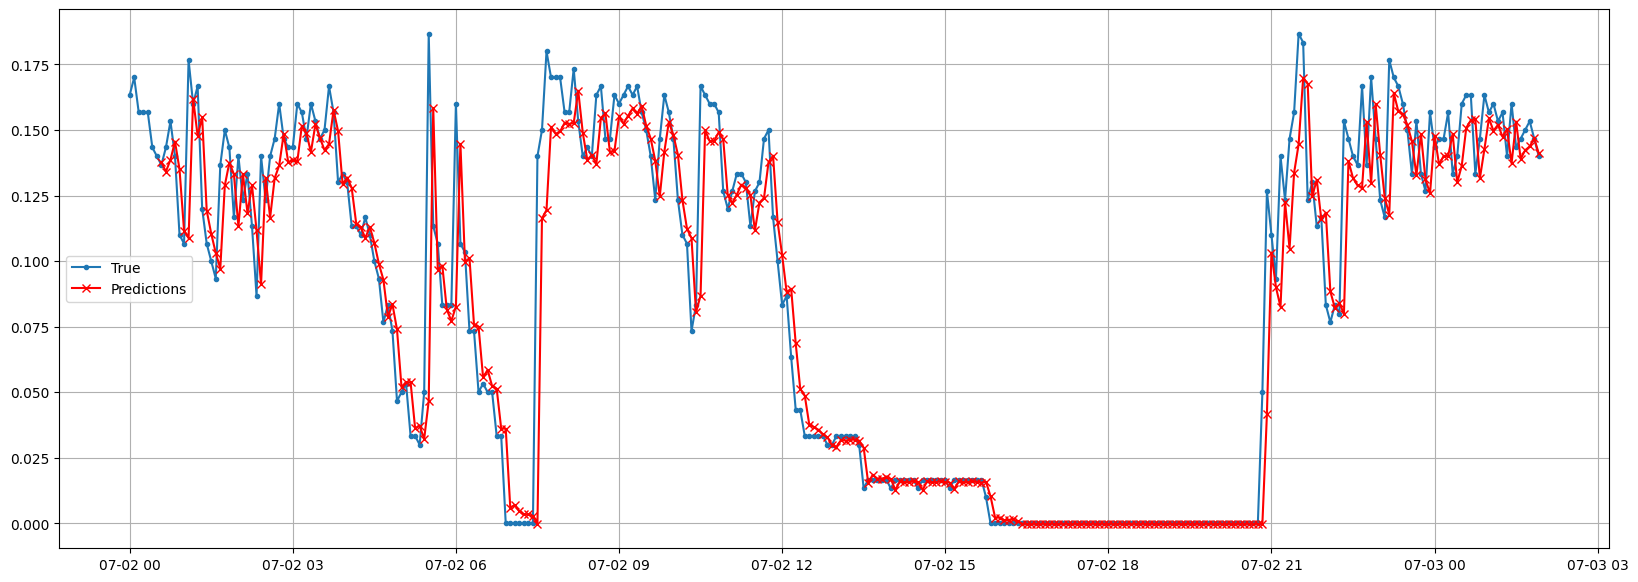

In [198]:
Y_pred = deep_model.predict(test_ds1)
Y_pred = pd.Series(Y_pred.flatten(), index=ts1.index[sequence_lenght:])

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test1['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

In [199]:
fit_and_evaluate(deep_model, train_ds2, valid_ds2)

Epoch 1/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 9.8868e-05 - mae: 0.0050 - val_loss: 2.6024e-05 - val_mae: 0.0044
Epoch 2/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 9.8247e-05 - mae: 0.0051 - val_loss: 3.4702e-05 - val_mae: 0.0058
Epoch 3/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 9.5720e-05 - mae: 0.0049 - val_loss: 5.2283e-05 - val_mae: 0.0084
Epoch 4/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - loss: 9.3729e-05 - mae: 0.0049 - val_loss: 3.1099e-05 - val_mae: 0.0055
Epoch 5/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 9.5015e-05 - mae: 0.0049 - val_loss: 2.1791e-05 - val_mae: 0.0054
Epoch 6/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 9.3968e-05 - mae: 0.0049 - val_loss: 2.0746e-05 - val_mae: 0.0051
Epoch 7/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 9.3600e-05 - mae: 0.0049 - val_loss: 3.7550e-05 - val_mae: 0.0066
Epoch 8/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - loss: 9.3381e-05 - mae: 0.0050 -

4098.016303032637

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


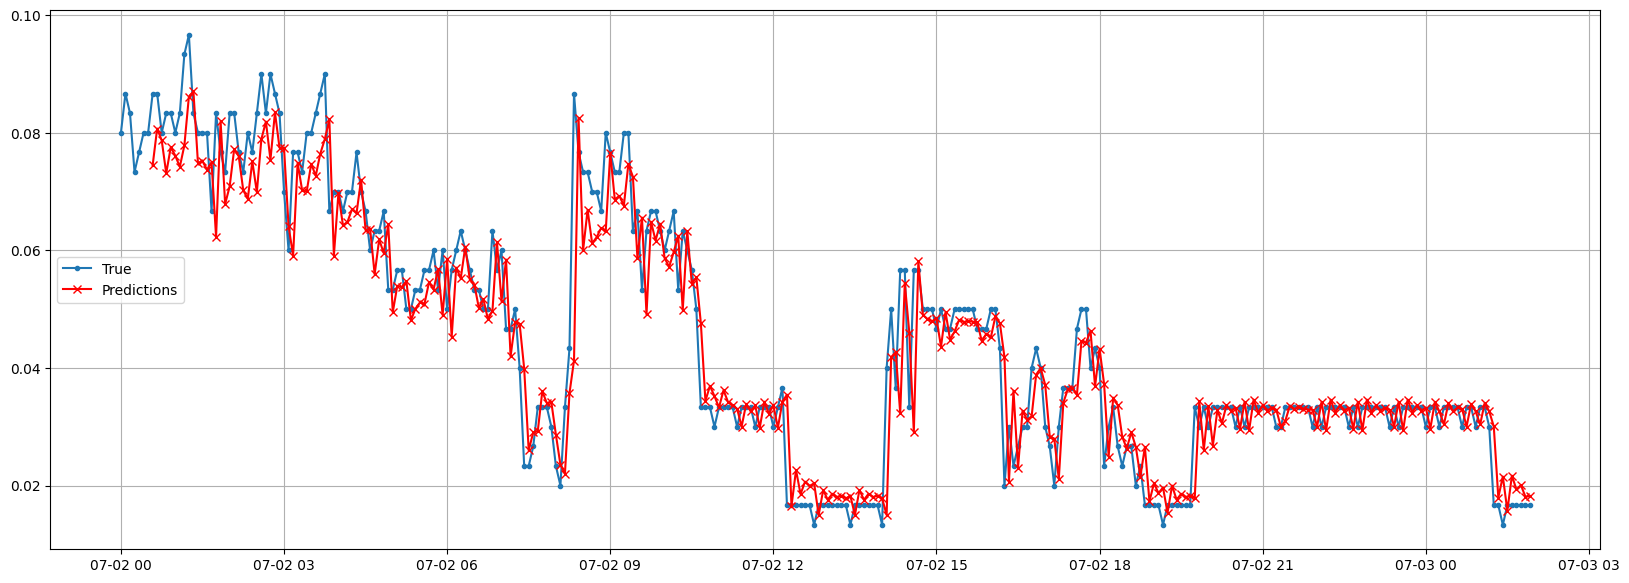

In [200]:
Y_pred = deep_model.predict(test_ds2)
Y_pred = pd.Series(Y_pred.flatten(), index=ts2.index[sequence_lenght:])

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test2['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

### Multivariate Series

In [201]:
# ENDPOINT 1:

tf.random.set_seed(seed)  # extra code – ensures reproducibility
train_mulvar_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    train1,
    targets=train1['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)
valid_mulvar_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    valid1,
    targets=valid1['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)
test_mulvar_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    test1,
    targets=test1['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)

In [202]:
# ENDPOINT 2:

tf.random.set_seed(seed)  # extra code – ensures reproducibility
train_mulvar_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    train2,
    targets=train2['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)
valid_mulvar_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    valid2,
    targets=valid2['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)
test_mulvar_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    test2,
    targets=test2['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)

#### Simple RNN

Notice that the only difference from the univar_model RNN we built earlier
is the input shape: at each time step, the model now receives num_features inputs instead of one.

In [72]:
mulvar_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(neurons, input_shape=[None, num_features]),
  tf.keras.layers.Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [203]:
fit_and_evaluate(mulvar_model, train_mulvar_ds1, valid_mulvar_ds1)

Epoch 1/10
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 3.1034e-04 - mae: 0.0151 - val_loss: 1.5205e-04 - val_mae: 0.0097
Epoch 2/10
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 2.0142e-04 - mae: 0.0114 - val_loss: 1.3459e-04 - val_mae: 0.0096
Epoch 3/10
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 1.8286e-04 - mae: 0.0108 - val_loss: 1.2726e-04 - val_mae: 0.0091
Epoch 4/10
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 1.7455e-04 - mae: 0.0105 - val_loss: 1.2545e-04 - val_mae: 0.0086
Epoch 5/10
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 1.7048e-04 - mae: 0.0103 - val_loss: 1.1990e-04 - val_mae: 0.0084
Epoch 6/10
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 1.6635e-04 - mae: 0.0102 - val_loss: 1.1832e-04 - val_mae: 0.0080
Epoch 7/10
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 1.6413e-04 - mae: 0.0100 - val_loss: 1.2084e-04 - val_mae: 0.0089
Epoch 8/10
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 1.6161e-04 - mae: 0.0100 - val_loss:

7924.331352114677

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


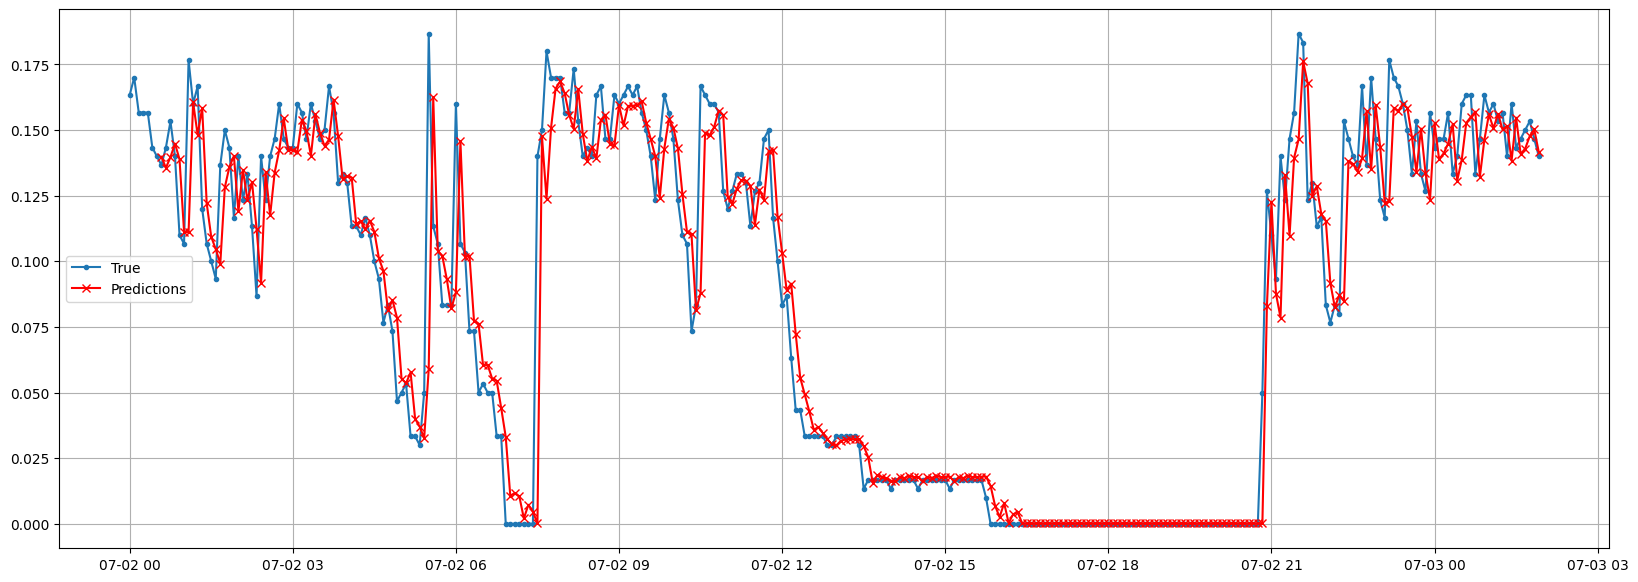

In [204]:
Y_pred = mulvar_model.predict(test_mulvar_ds1)
Y_pred = pd.Series(Y_pred.flatten(), index=ts1.index[sequence_lenght:])

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test1['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

In [205]:
fit_and_evaluate(mulvar_model, train_mulvar_ds2, valid_mulvar_ds2)

Epoch 1/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 1.7594e-04 - mae: 0.0077 - val_loss: 2.2944e-05 - val_mae: 0.0044
Epoch 2/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 1.0915e-04 - mae: 0.0050 - val_loss: 2.2414e-05 - val_mae: 0.0050
Epoch 3/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 9.8241e-05 - mae: 0.0047 - val_loss: 1.9212e-05 - val_mae: 0.0041
Epoch 4/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 9.2465e-05 - mae: 0.0046 - val_loss: 1.8098e-05 - val_mae: 0.0032
Epoch 5/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 8.7920e-05 - mae: 0.0044 - val_loss: 1.6898e-05 - val_mae: 0.0036
Epoch 6/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 8.6463e-05 - mae: 0.0044 - val_loss: 1.6591e-05 - val_mae: 0.0031
Epoch 7/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 8.5122e-05 - mae: 0.0043 - val_loss: 1.8661e-05 - val_mae: 0.0043
Epoch 8/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 8.3402e-05 - mae: 0.0043 - val_loss: 

3148.237243294716

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


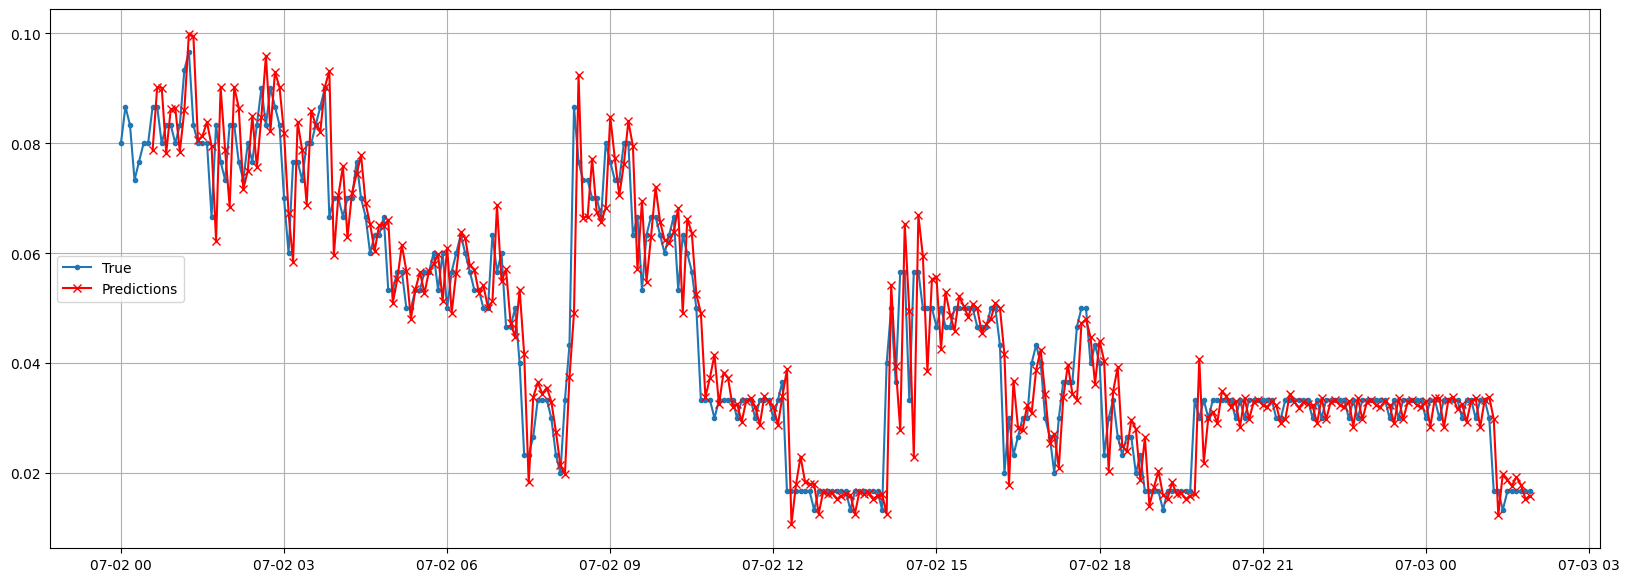

In [206]:
Y_pred = mulvar_model.predict(test_mulvar_ds2)
Y_pred = pd.Series(Y_pred.flatten(), index=ts2.index[sequence_lenght:])

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test2['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

## Forecasting Several Time Steps Ahead

### Univariate Series

Consideriamo sempre:
* tr = train['avg_invocations_rate']
* vl = valid['avg_invocations_rate']

#### Simple RNN

The first option is to take the univar_model RNN we trained earlier for the
rail time series, make it predict the next value, and add that value to the inputs,
acting as if the predicted value had actually occurred; we would then use the
model again to predict the following value, and so on.

---
If the model makes an error at one time step, then the forecasts for the
following time steps are impacted as well: the errors tend to accumulate.
So, it’s preferable to use this technique only for a small number of steps.

 1 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
 2 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
 3 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
 4 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
 5 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
 6 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
 7 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


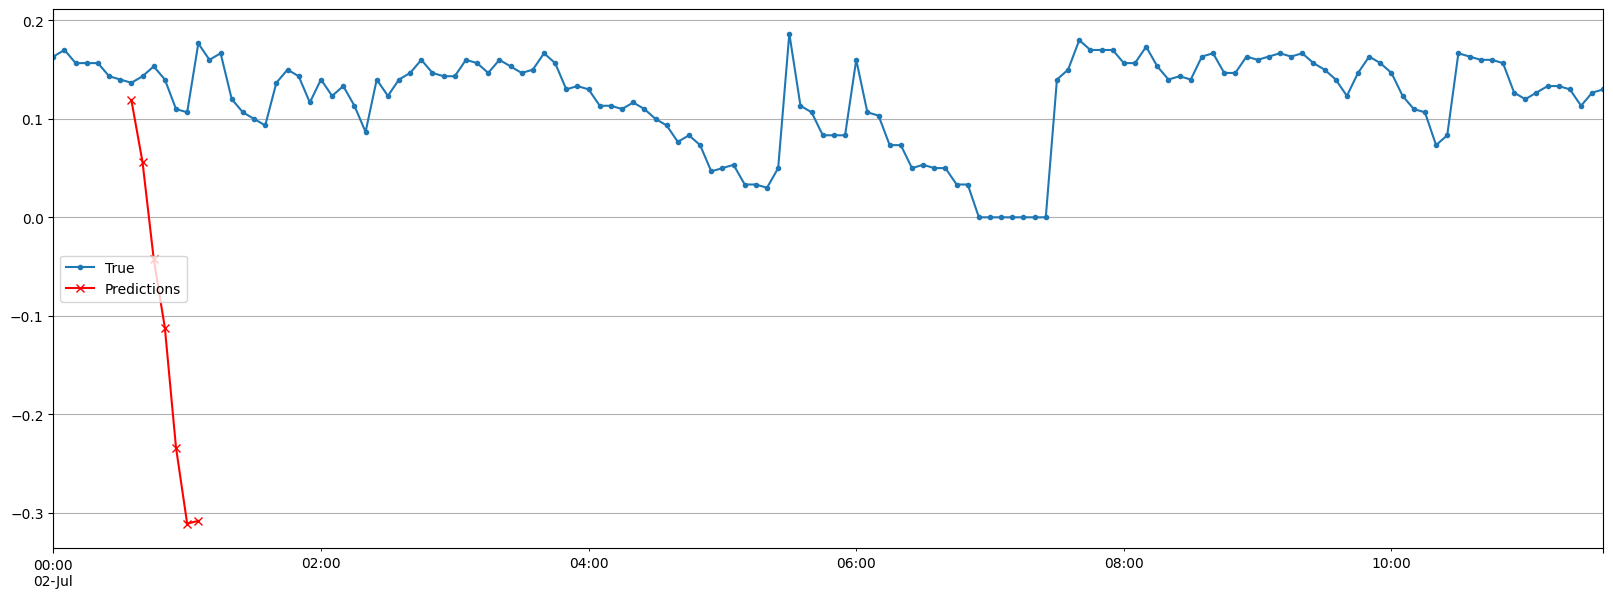

In [208]:
X = ts1[:-sequence_lenght].to_numpy()[np.newaxis, :sequence_lenght, np.newaxis]
for step_ahead in range(prediction_lenght):
  print(f" {step_ahead+1} step ahead")
  y_pred_one = univar_model.predict(X)
  X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

Y_pred = pd.Series(X[0, -prediction_lenght:, 0], index=pd.date_range(start=ts1.index[sequence_lenght], end=ts1.index[sequence_lenght+prediction_lenght-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts1[:(sequence_lenght*20)])[start:start].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

 1 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
 2 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
 3 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
 4 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
 5 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
 6 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
 7 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


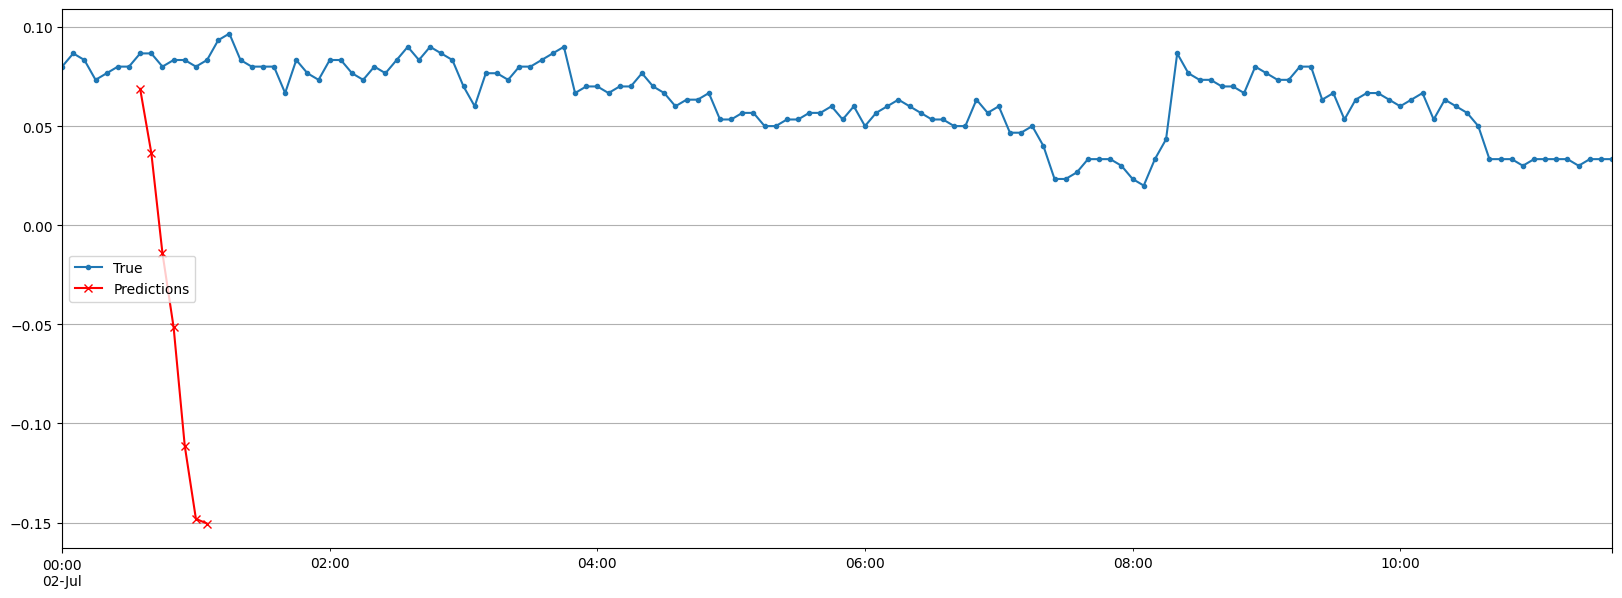

In [209]:
X = ts2[:-sequence_lenght].to_numpy()[np.newaxis, :sequence_lenght, np.newaxis]
for step_ahead in range(prediction_lenght):
  print(f" {step_ahead+1} step ahead")
  y_pred_one = univar_model.predict(X)
  X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

Y_pred = pd.Series(X[0, -prediction_lenght:, 0], index=pd.date_range(start=ts2.index[sequence_lenght], end=ts2.index[sequence_lenght+prediction_lenght-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts2[:(sequence_lenght*20)]).plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### DeepRNN

 1 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
 2 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
 3 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
 4 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
 5 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
 6 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
 7 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


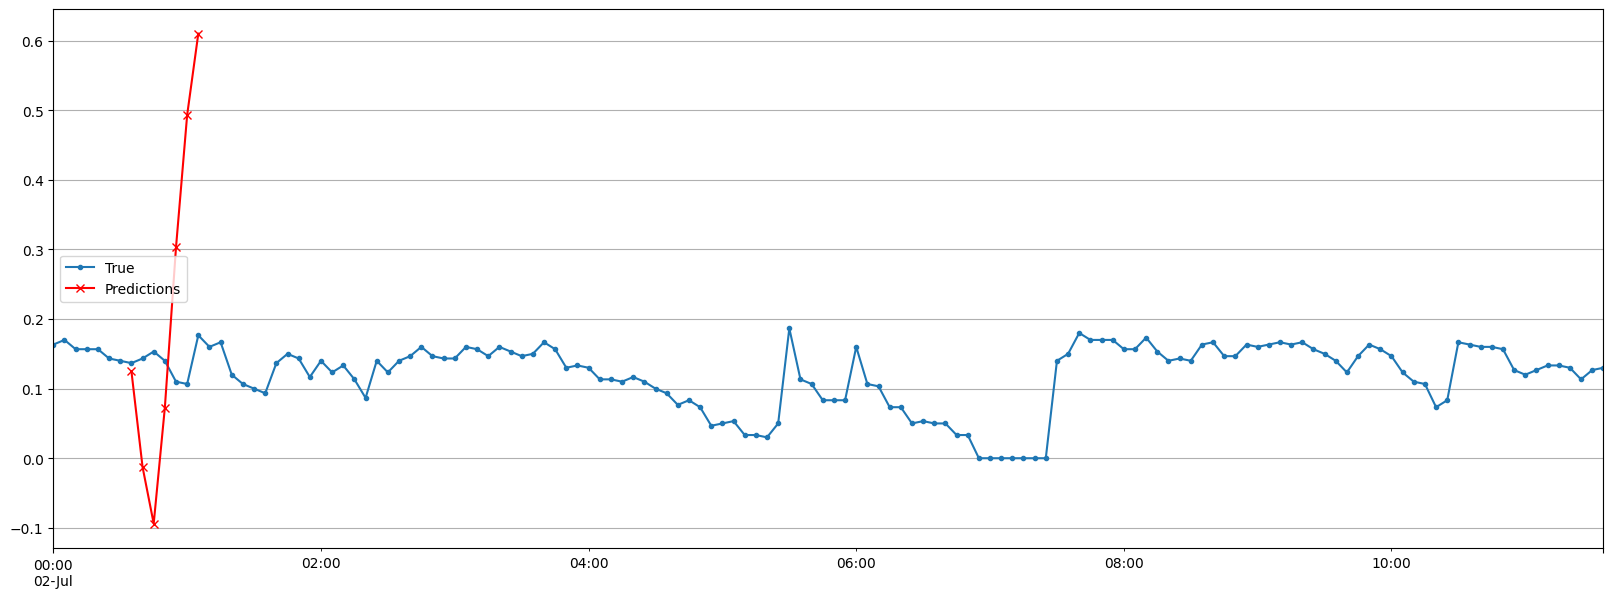

In [211]:
X = ts1.to_numpy()[np.newaxis, :sequence_lenght, np.newaxis]
# run a for loop running multiple times the univar_model and extract the last prediction each time
# concatenate that to the data and keep predicting
for step_ahead in range(prediction_lenght):
  print(f" {step_ahead+1} step ahead")
  y_pred_one = deep_model.predict(X)
  X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

Y_pred = pd.Series(X[0, -prediction_lenght:, 0], index=pd.date_range(start=ts1.index[prediction_lenght], end=ts1.index[sequence_lenght+prediction_lenght-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts1[:(sequence_lenght*20)])[start:start].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

 1 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
 2 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
 3 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
 4 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
 5 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
 6 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
 7 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


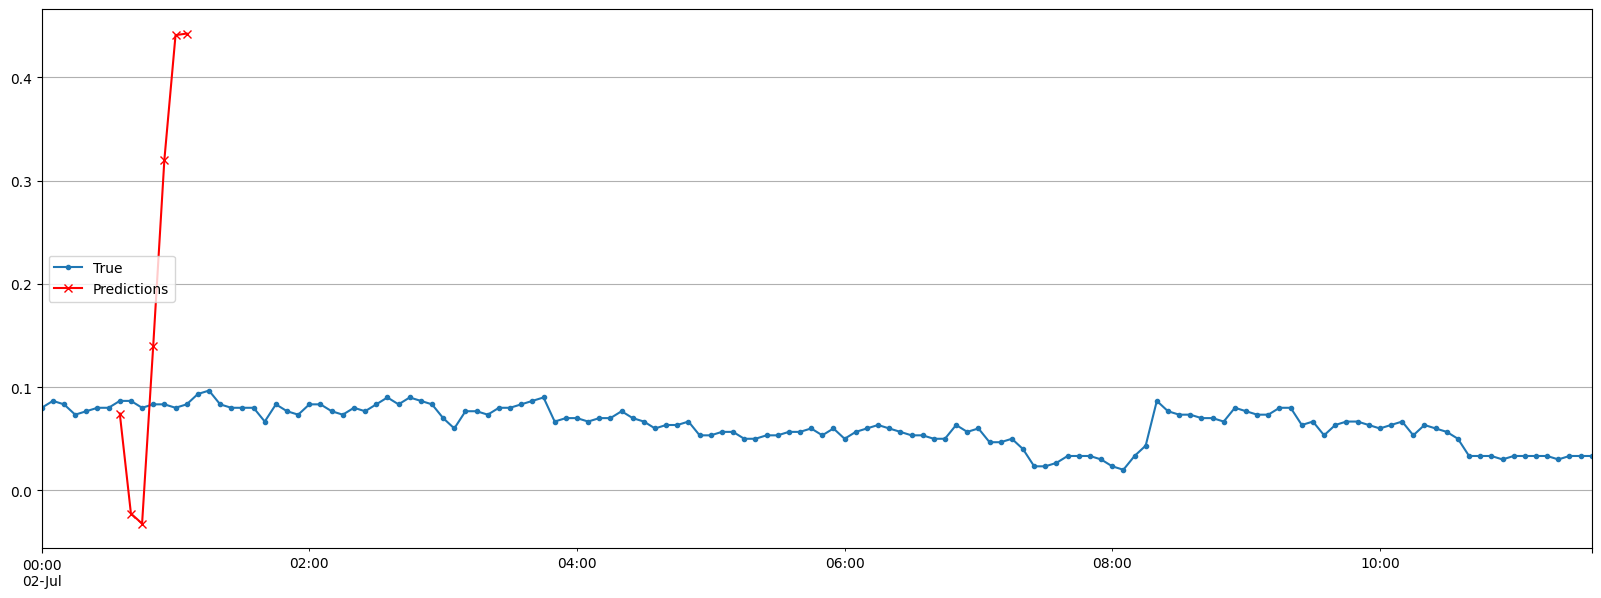

In [212]:
X = ts2.to_numpy()[np.newaxis, :sequence_lenght, np.newaxis]
# run a for loop running multiple times the univar_model and extract the last prediction each time
# concatenate that to the data and keep predicting
for step_ahead in range(prediction_lenght):
  print(f" {step_ahead+1} step ahead")
  y_pred_one = deep_model.predict(X)
  X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

Y_pred = pd.Series(X[0, -prediction_lenght:, 0], index=pd.date_range(start=ts2.index[prediction_lenght], end=ts2.index[sequence_lenght+prediction_lenght-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts2[:(sequence_lenght*20)])[start:start].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

### Multivariate Series

In [213]:
def split_inputs_and_targets(mulvar_series, ahead=prediction_lenght, target_col=1):
  return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

In [214]:
# ENDPOINT 1:

ahead_train_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    train1,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
).map(split_inputs_and_targets)

ahead_valid_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    valid1,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size
).map(split_inputs_and_targets)

ahead_test_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    test1,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size
).map(split_inputs_and_targets)

In [215]:
# ENDPOINT 2:

ahead_train_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    train2,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
).map(split_inputs_and_targets)

ahead_valid_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    valid2,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size
).map(split_inputs_and_targets)

ahead_test_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    test2,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size
).map(split_inputs_and_targets)

#### Sequence-to-Vector RNN

Train an RNN to predict the next 14 values in one shot.

In [216]:
ahead_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(neurons, input_shape=[None, num_features]),
  tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [217]:
fit_and_evaluate(ahead_model, ahead_train_ds1, ahead_valid_ds1)

Epoch 1/10
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.1115 - mae: 0.2692 - val_loss: 0.0690 - val_mae: 0.1869
Epoch 2/10
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0943 - mae: 0.2241 - val_loss: 0.0677 - val_mae: 0.1753
Epoch 3/10
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0935 - mae: 0.2225 - val_loss: 0.0677 - val_mae: 0.1801
Epoch 4/10
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0931 - mae: 0.2214 - val_loss: 0.0673 - val_mae: 0.1826
Epoch 5/10
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0930 - mae: 0.2215 - val_loss: 0.0675 - val_mae: 0.1916
Epoch 6/10
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0924 - mae: 0.2209 - val_loss: 0.0671 - val_mae: 0.1875
Epoch 7/10
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0925 - mae: 0.2209 - val_loss: 0.0671 - val_mae: 0.1903
Epoch 8/10
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0919 - mae: 0.2199 - val_loss: 0.0670 - val_mae: 0.1896
Epoch 9/10
1297/1297 ━━━━━━━━━━━━━━━━━━━

168707.32605457306

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


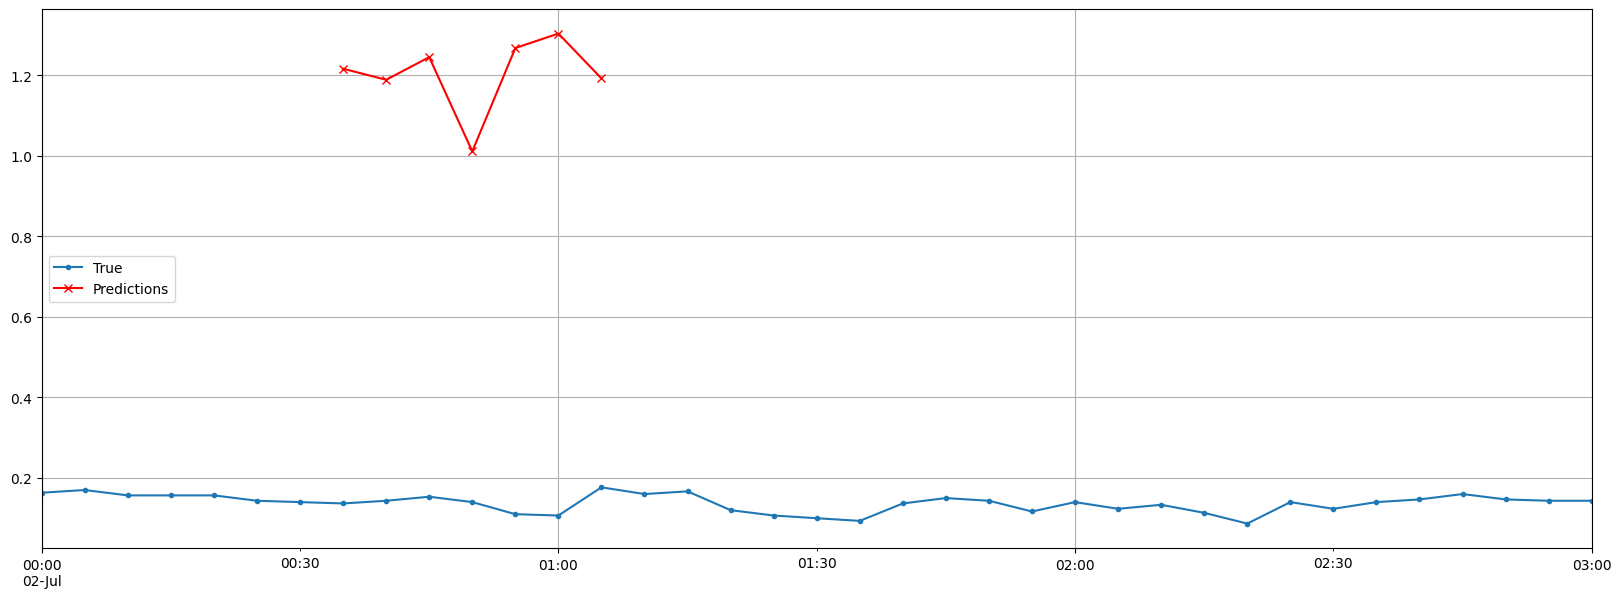

In [223]:
X = test1.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = ahead_model.predict(X)

Y_pred = pd.Series(Y_pred[0], index=pd.date_range(start=ts1.index[sequence_lenght], end=ts1.index[sequence_lenght+prediction_lenght-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts1)["2023-07-02 00:00":"2023-07-02 03:00"].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
plt.show()

In [221]:
fit_and_evaluate(ahead_model, ahead_train_ds2, ahead_valid_ds2)

Epoch 1/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0651 - mae: 0.1581 - val_loss: 0.0336 - val_mae: 0.1035
Epoch 2/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0595 - mae: 0.1461 - val_loss: 0.0326 - val_mae: 0.1050
Epoch 3/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0586 - mae: 0.1443 - val_loss: 0.0323 - val_mae: 0.1048
Epoch 4/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0582 - mae: 0.1443 - val_loss: 0.0319 - val_mae: 0.1009
Epoch 5/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.0576 - mae: 0.1431 - val_loss: 0.0317 - val_mae: 0.0929
Epoch 6/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0571 - mae: 0.1426 - val_loss: 0.0316 - val_mae: 0.1014
Epoch 7/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0569 - mae: 0.1419 - val_loss: 0.0312 - val_mae: 0.1015
Epoch 8/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0566 - mae: 0.1414 - val_loss: 0.0311 - val_mae: 0.0981
Epoch 9/10
1307/1307 ━━━━━━━━━━━━━━━━

84224.47741031647

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


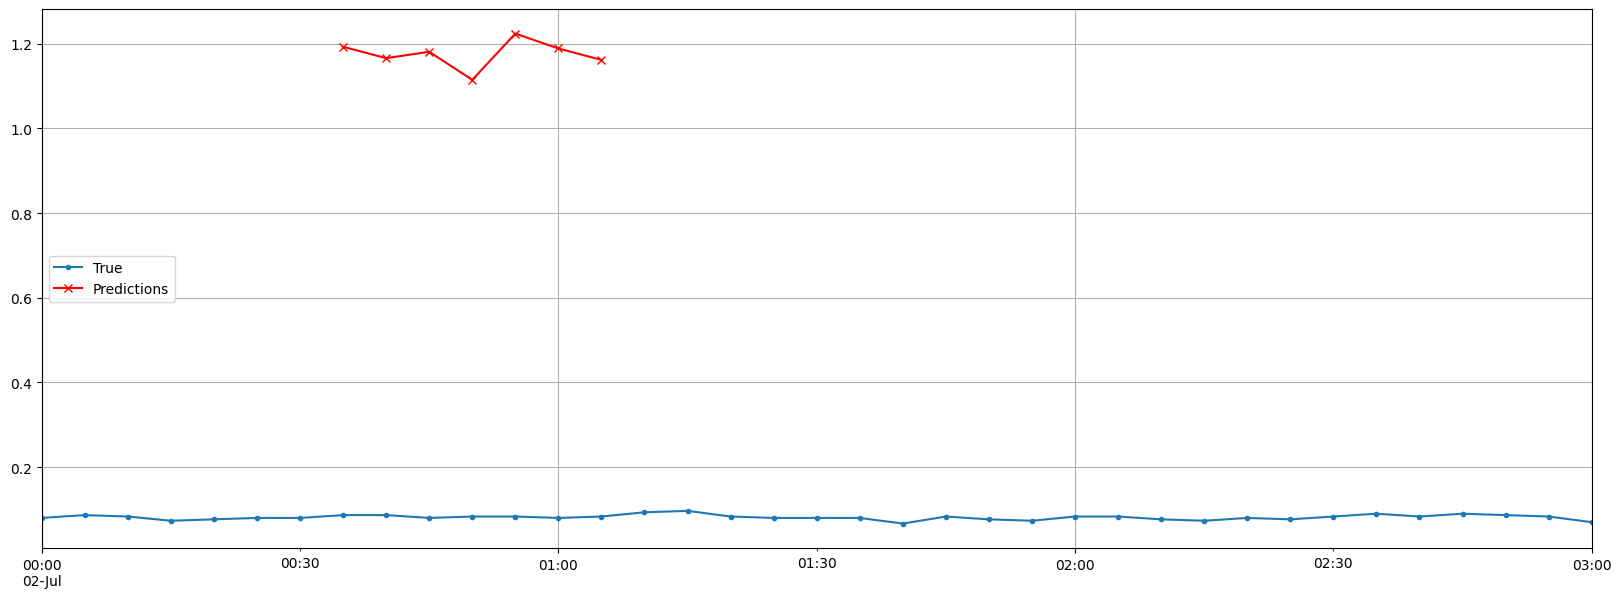

In [224]:
X = test2.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = ahead_model.predict(X)
Y_pred = pd.Series(Y_pred[0], index=pd.date_range(start=ts2.index[sequence_lenght], end=ts2.index[sequence_lenght+prediction_lenght-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts2)["2023-07-02 00:00":"2023-07-02 03:00"].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### Sequence-to-Sequence RNN

In [225]:
def to_windows(dataset, length):
  dataset = dataset.window(length, shift=1, drop_remainder=True)
  return dataset.flat_map(lambda window_ds: window_ds.batch(length))

def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1, batch_size=32, shuffle=False, seed=None):
  ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
  ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
  if shuffle:
    ds = ds.shuffle(8 * batch_size, seed=seed)
  return ds.batch(batch_size)

In [226]:
seq2seq_train1 = to_seq2seq_dataset(train1, seq_length=sequence_lenght, ahead=prediction_lenght, shuffle=True, seed=seed)
seq2seq_valid1 = to_seq2seq_dataset(valid1, seq_length=sequence_lenght, ahead=prediction_lenght)
seq2seq_test1 = to_seq2seq_dataset(test1, seq_length=sequence_lenght, ahead=prediction_lenght)

seq2seq_train2 = to_seq2seq_dataset(train2, seq_length=sequence_lenght, ahead=prediction_lenght, shuffle=True, seed=seed)
seq2seq_valid2 = to_seq2seq_dataset(valid2, seq_length=sequence_lenght, ahead=prediction_lenght)
seq2seq_test2 = to_seq2seq_dataset(test2, seq_length=sequence_lenght, ahead=prediction_lenght)

Instead of training the model to forecast the next 14 values only at the very last time step, we can train it to forecast the next 14 values at each and every time step.
In other words, we can turn this sequence-to-vector RNN into a sequence-to-sequence RNN.

* The targets are sequences of consecutive windows, shifted by one time step at each time step;
* The target is not a vector anymore, but a sequence of the same length as the inputs, containing a (prediction_lenght)-dimensional vector at each step.

It is almost identical to our previous model: the only difference is that we set
return_sequences=True in the SimpleRNN layer. This way, it will
output a sequence of vectors (each of size 'batch_size'), instead of outputting a single
vector at the last time step. The Dense layer is smart enough to handle
sequences as input: it will be applied at each time step, taking a 'batch_size'-dimensional
vector as input and outputting a 'prediction_lenght'-dimensional vector.

In [227]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(neurons, return_sequences=True, input_shape=[None, num_features]),
    tf.keras.layers.Dense(prediction_lenght)
    # equivalent: tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
    # also equivalent: tf.keras.layers.Conv1D(14, kernel_size=1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [228]:
fit_and_evaluate(seq2seq_model, seq2seq_train1, seq2seq_valid1)

Epoch 1/10
   1288/Unknown 13s 9ms/step - loss: 0.1294 - mae: 0.2970

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1297/1297 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 0.1292 - mae: 0.2966 - val_loss: 0.0673 - val_mae: 0.1652
Epoch 2/10
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.1060 - mae: 0.2443 - val_loss: 0.0668 - val_mae: 0.1600
Epoch 3/10
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 0.1057 - mae: 0.2435 - val_loss: 0.0664 - val_mae: 0.1599
Epoch 4/10
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 0.1053 - mae: 0.2418 - val_loss: 0.0660 - val_mae: 0.1627
Epoch 5/10
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.1048 - mae: 0.2417 - val_loss: 0.0661 - val_mae: 0.1575
Epoch 6/10
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 0.1042 - mae: 0.2396 - val_loss: 0.0659 - val_mae: 0.1577
Epoch 7/10
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 0.1041 - mae: 0.2404 - val_loss: 0.0658 - val_mae: 0.1584
Epoch 8/10
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.1041 - mae: 0.2396 - val_loss: 0.0656 - val_mae: 0.1596
Epoch 9/10
1297/1297 ━━━━━━━━━━━━━━

156810.86480617523

In [232]:
Y_pred_valid = seq2seq_model.predict(seq2seq_test1)
for ahead in range(prediction_lenght):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=test1.index[sequence_lenght + ahead : -prediction_lenght + ahead])
    mae = (preds - test1["avg_invocations_rate"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE for +1: 987,324
MAE for +2: 940,037
MAE for +3: 935,471
MAE for +4: 961,704
MAE for +5: 888,577
MAE for +6: 898,897
MAE for +7: 939,994


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


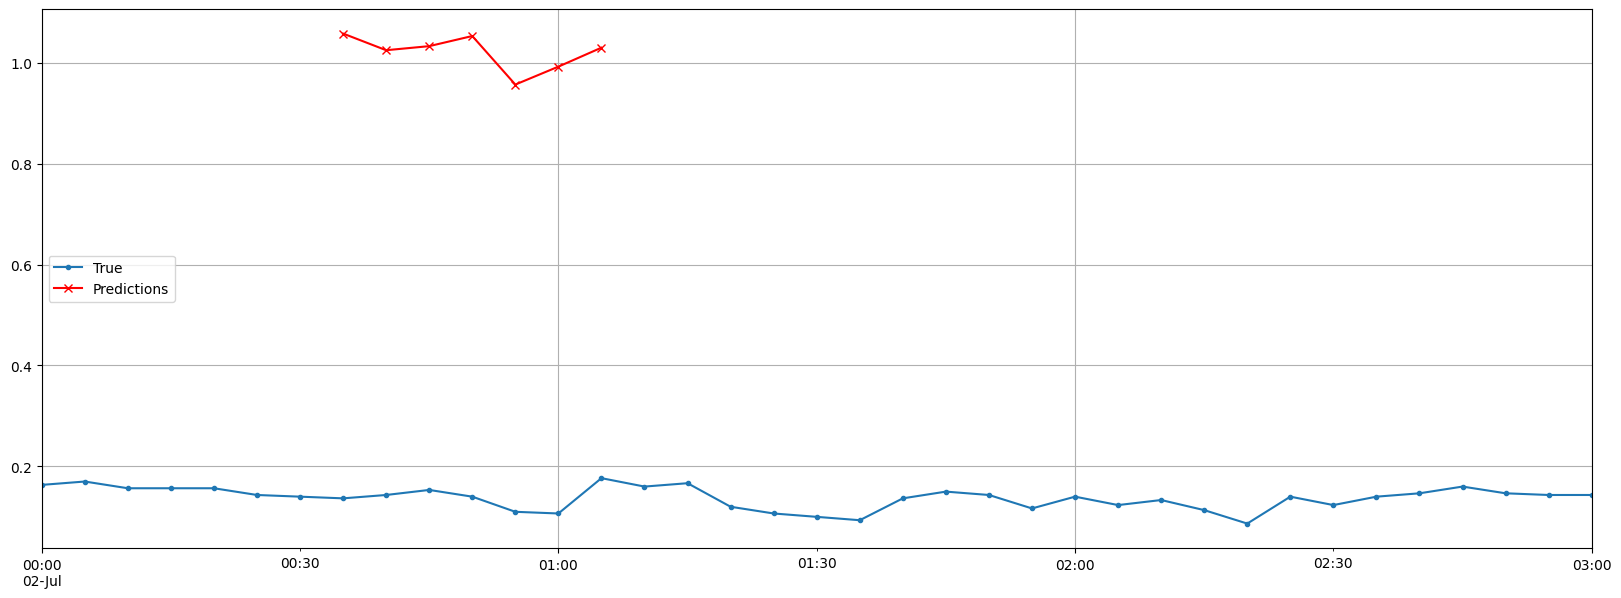

In [233]:
X = test1.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = seq2seq_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts1.index[sequence_lenght], end=ts1.index[sequence_lenght+prediction_lenght-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts1)["2023-07-02 00:00":"2023-07-02 03:00"].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

In [234]:
fit_and_evaluate(seq2seq_model, seq2seq_train2, seq2seq_valid2)

Epoch 1/10
   1304/Unknown 16s 10ms/step - loss: 0.0883 - mae: 0.1995

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1307/1307 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - loss: 0.0883 - mae: 0.1993 - val_loss: 0.0334 - val_mae: 0.1052
Epoch 2/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 0.0881 - mae: 0.1988 - val_loss: 0.0335 - val_mae: 0.1079
Epoch 3/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 0.0880 - mae: 0.1992 - val_loss: 0.0332 - val_mae: 0.1020
Epoch 4/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.0874 - mae: 0.1980 - val_loss: 0.0332 - val_mae: 0.1013
Epoch 5/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - loss: 0.0871 - mae: 0.1976 - val_loss: 0.0332 - val_mae: 0.1021
Epoch 6/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.0870 - mae: 0.1970 - val_loss: 0.0334 - val_mae: 0.1058
Epoch 7/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.0864 - mae: 0.1961 - val_loss: 0.0334 - val_mae: 0.1059
Epoch 8/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 0.0865 - mae: 0.1961 - val_loss: 0.0332 - val_mae: 0.1018
Epoch 9/10
1307/1307 ━━━━━━━━━━━━━━

101340.24918079376

In [235]:
Y_pred_valid = seq2seq_model.predict(seq2seq_test2)
for ahead in range(prediction_lenght):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=test2.index[sequence_lenght + ahead : -prediction_lenght + ahead])
    mae = (preds - test2["avg_invocations_rate"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE for +1: 1,067,714
MAE for +2: 1,088,607
MAE for +3: 1,076,171
MAE for +4: 1,068,698
MAE for +5: 1,034,955
MAE for +6: 1,060,186
MAE for +7: 1,041,466


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


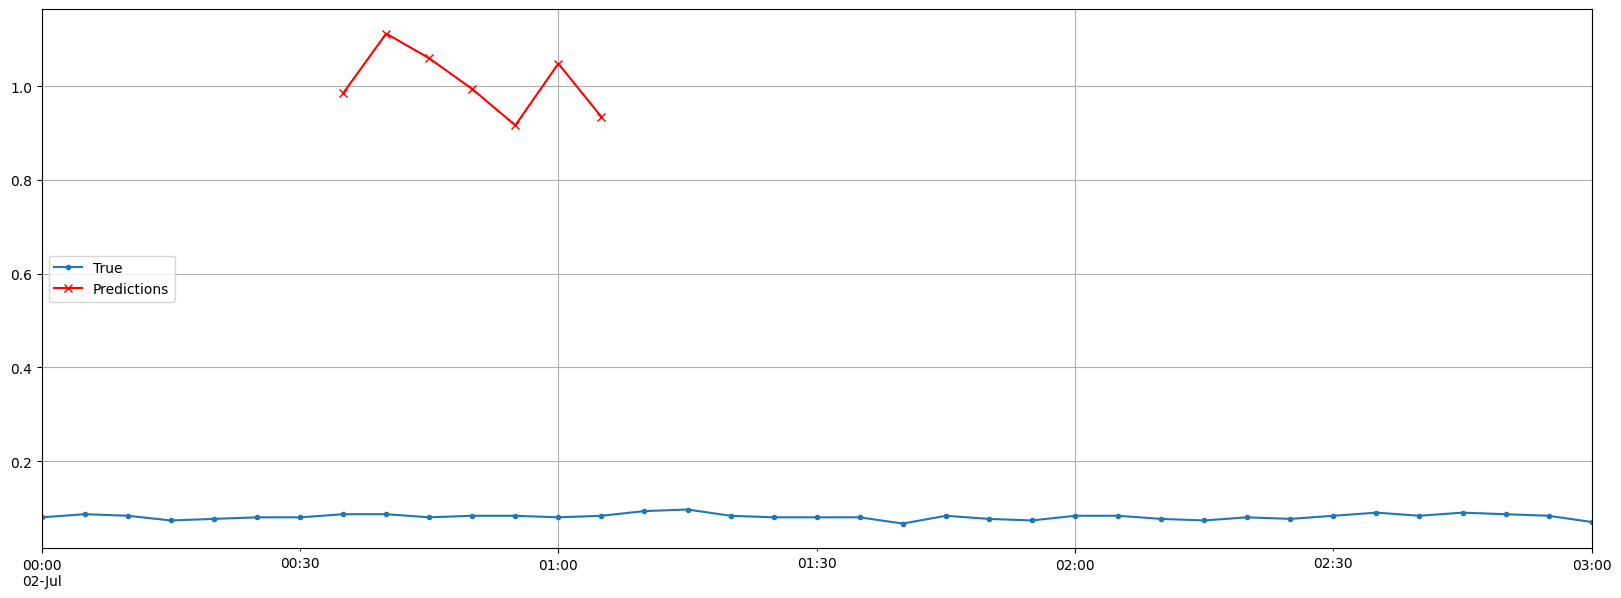

In [237]:
X = test2.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = seq2seq_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts2.index[sequence_lenght], end=ts2.index[sequence_lenght+prediction_lenght-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts2)["2023-07-02 00:00":"2023-07-02 03:00"].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

# - FINO QUI -

#### RNN with layer normalization

In [96]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [97]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(neurons), return_sequences=True, input_shape=[None, num_features]),
    tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [98]:
fit_and_evaluate(custom_ln_model, seq2seq_train1, seq2seq_valid1)

Epoch 1/10
    698/Unknown 14s 17ms/step - loss: 0.3747 - mae: 0.7106

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


703/703 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 0.3742 - mae: 0.7100 - val_loss: 0.1909 - val_mae: 0.4489
Epoch 2/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.3463 - mae: 0.6723 - val_loss: 0.1883 - val_mae: 0.4455
Epoch 3/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.3432 - mae: 0.6679 - val_loss: 0.1871 - val_mae: 0.4424
Epoch 4/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.3428 - mae: 0.6671 - val_loss: 0.1866 - val_mae: 0.4411
Epoch 5/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.3423 - mae: 0.6662 - val_loss: 0.1863 - val_mae: 0.4410
Epoch 6/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.3412 - mae: 0.6647 - val_loss: 0.1862 - val_mae: 0.4415
Epoch 7/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.3420 - mae: 0.6658 - val_loss: 0.1860 - val_mae: 0.4409
Epoch 8/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.3403 - mae: 0.6634 - val_loss: 0.1858 - val_mae: 0.4400
Epoch 9/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - 

439232.4984073639

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


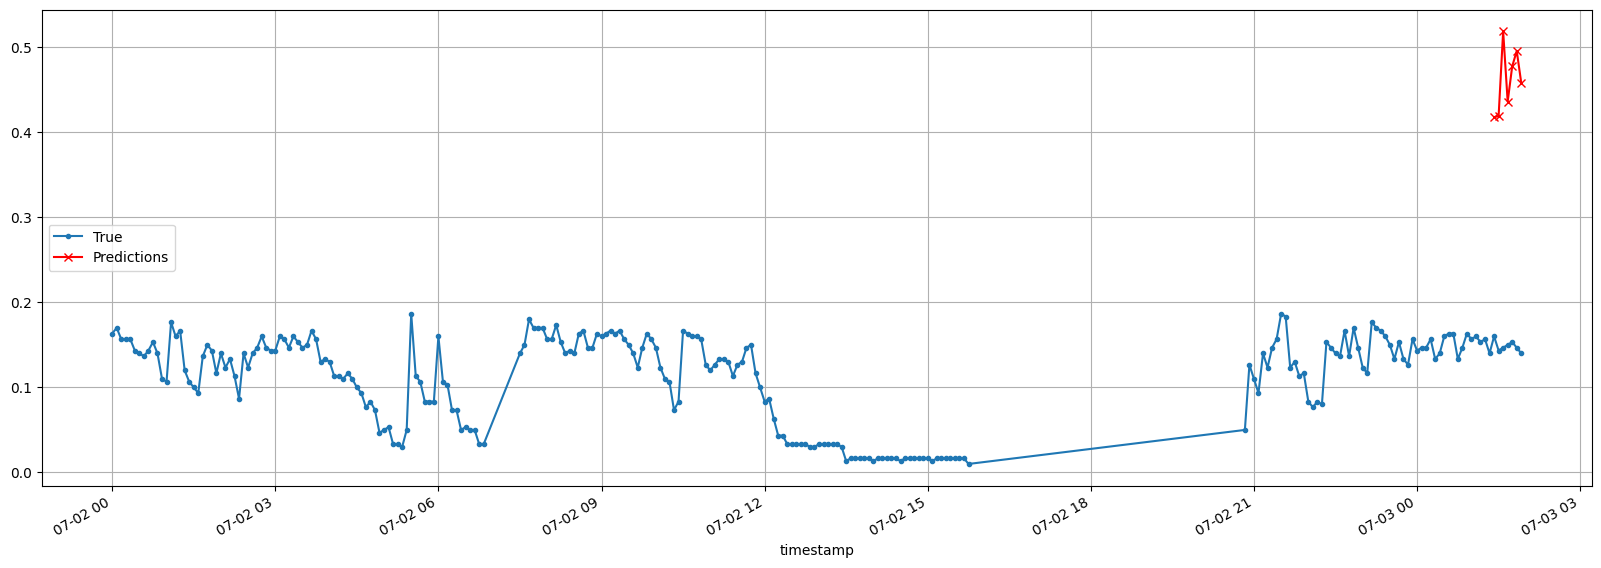

In [99]:
X = test1.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = custom_ln_model.predict(X)  # but then [0, -1] because only the last time step's output

Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts1.index[-sequence_lenght], end=ts1.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts1)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

In [100]:
fit_and_evaluate(custom_ln_model, seq2seq_train2, seq2seq_valid2)

Epoch 1/10
    582/Unknown 8s 10ms/step - loss: 0.1670 - mae: 0.3085

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


590/590 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.1677 - mae: 0.3094 - val_loss: 0.0343 - val_mae: 0.1088
Epoch 2/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.1617 - mae: 0.2987 - val_loss: 0.0408 - val_mae: 0.1243
Epoch 3/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.1508 - mae: 0.2860 - val_loss: 0.0393 - val_mae: 0.1204
Epoch 4/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.1428 - mae: 0.2748 - val_loss: 0.0411 - val_mae: 0.1188
Epoch 5/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.1438 - mae: 0.2754 - val_loss: 0.0365 - val_mae: 0.1093
Epoch 6/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.1411 - mae: 0.2705 - val_loss: 0.0330 - val_mae: 0.0980
Epoch 7/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.1407 - mae: 0.2693 - val_loss: 0.0294 - val_mae: 0.0834
Epoch 8/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.1398 - mae: 0.2684 - val_loss: 0.0273 - val_mae: 0.0774
Epoch 9/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - 

72351.26942396164

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


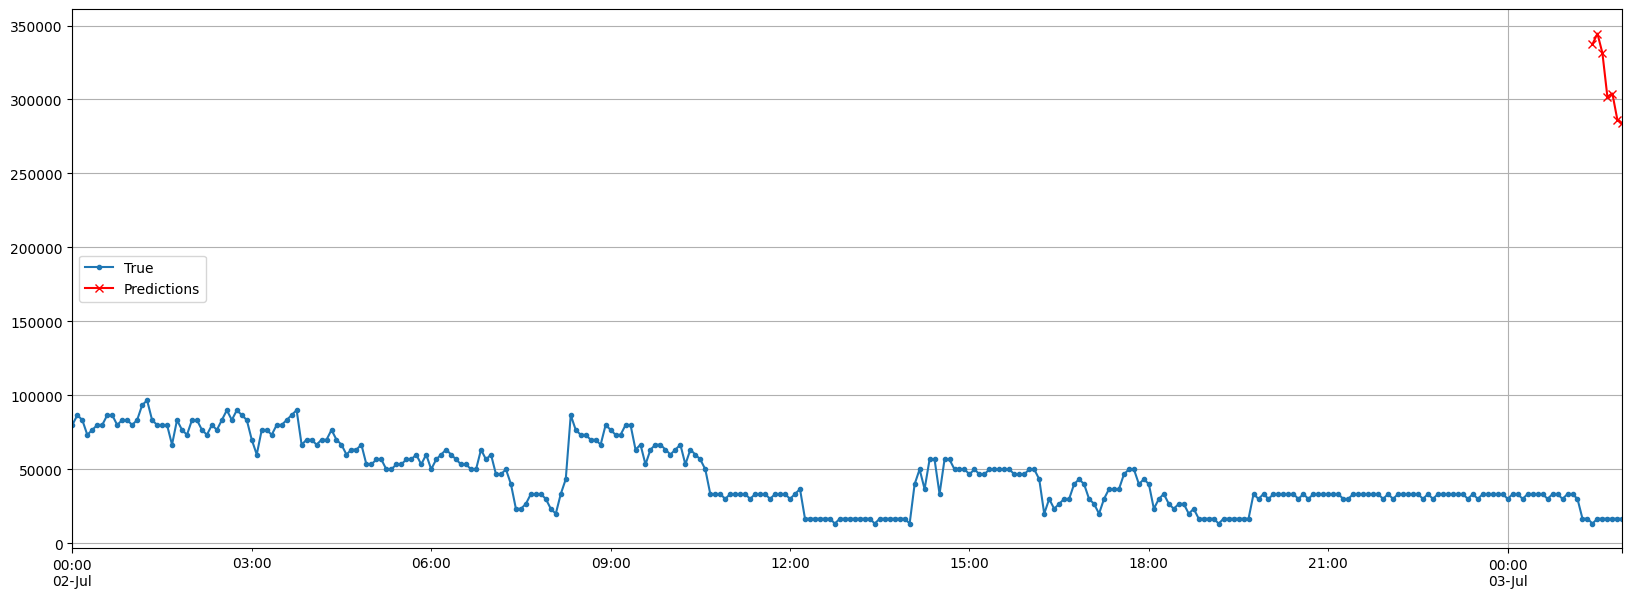

In [101]:
X = test2.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = custom_ln_model.predict(X)  # but then [0, -1] because only the last time step's output

Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts2.index[-sequence_lenght], end=ts2.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts2 * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

 #### LSTM

In [102]:
lstm = tf.keras.Sequential([
  tf.keras.layers.LSTM(neurons, return_sequences=True, input_shape=[None, num_features]),
  tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [103]:
fit_and_evaluate(lstm, seq2seq_train1, seq2seq_valid1)

Epoch 1/10
    694/Unknown 8s 9ms/step - loss: 0.3585 - mae: 0.7133

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.3577 - mae: 0.7122 - val_loss: 0.1883 - val_mae: 0.4414
Epoch 2/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.3445 - mae: 0.6731 - val_loss: 0.1882 - val_mae: 0.4397
Epoch 3/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 0.3438 - mae: 0.6718 - val_loss: 0.1883 - val_mae: 0.4395
Epoch 4/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.3425 - mae: 0.6703 - val_loss: 0.1881 - val_mae: 0.4373
Epoch 5/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.3422 - mae: 0.6697 - val_loss: 0.1880 - val_mae: 0.4374
Epoch 6/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.3430 - mae: 0.6706 - val_loss: 0.1879 - val_mae: 0.4372
Epoch 7/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.3418 - mae: 0.6691 - val_loss: 0.1877 - val_mae: 0.4364
Epoch 8/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.3421 - mae: 0.6692 - val_loss: 0.1876 - val_mae: 0.4363
Epoch 9/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - l

436265.5282020569

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


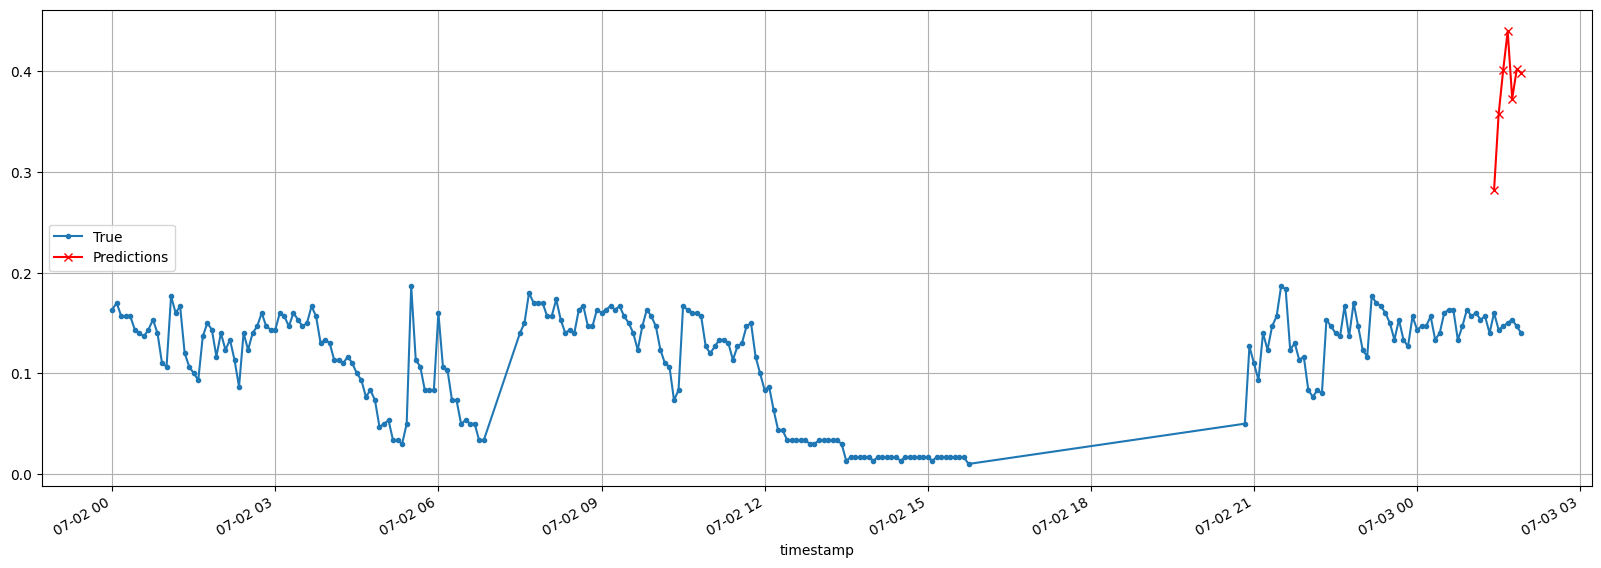

In [104]:
X = test1.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = lstm.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts1.index[-sequence_lenght], end=ts1.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts1)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

In [105]:
fit_and_evaluate(lstm, seq2seq_train2, seq2seq_valid2)

Epoch 1/10
    584/Unknown 7s 9ms/step - loss: 0.1637 - mae: 0.2999

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


590/590 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.1641 - mae: 0.3006 - val_loss: 0.0318 - val_mae: 0.1289
Epoch 2/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.1498 - mae: 0.2888 - val_loss: 0.0345 - val_mae: 0.1449
Epoch 3/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.1457 - mae: 0.2825 - val_loss: 0.0401 - val_mae: 0.1574
Epoch 4/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.1490 - mae: 0.2828 - val_loss: 0.0378 - val_mae: 0.1485
Epoch 5/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.1457 - mae: 0.2784 - val_loss: 0.0342 - val_mae: 0.1292
Epoch 6/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.1447 - mae: 0.2755 - val_loss: 0.0335 - val_mae: 0.1243
Epoch 7/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.1431 - mae: 0.2736 - val_loss: 0.0323 - val_mae: 0.1160
Epoch 8/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.1421 - mae: 0.2729 - val_loss: 0.0289 - val_mae: 0.0990
Epoch 9/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - lo

94161.80849075317

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


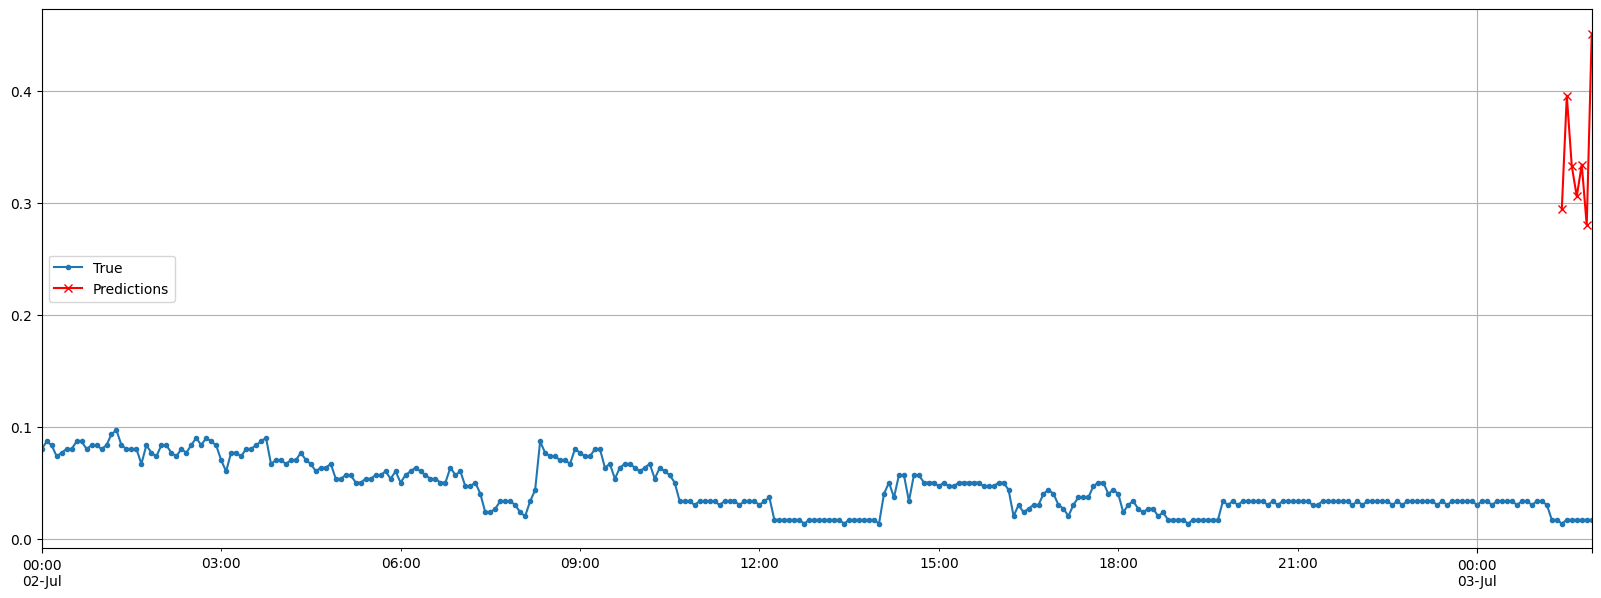

In [106]:
X = test2.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = lstm.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts2.index[-sequence_lenght], end=ts2.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts2)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### GRU

The GRU cell is a simplified version of the LSTM cell...

In [107]:
gru = tf.keras.Sequential([
  tf.keras.layers.GRU(neurons, return_sequences=True, input_shape=[None, num_features]),
  tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [108]:
fit_and_evaluate(gru, seq2seq_train1, seq2seq_valid1)

Epoch 1/10
    700/Unknown 9s 10ms/step - loss: 0.3504 - mae: 0.6923

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


703/703 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.3502 - mae: 0.6919 - val_loss: 0.1863 - val_mae: 0.4383
Epoch 2/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.3439 - mae: 0.6728 - val_loss: 0.1864 - val_mae: 0.4370
Epoch 3/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.3423 - mae: 0.6702 - val_loss: 0.1863 - val_mae: 0.4350
Epoch 4/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.3417 - mae: 0.6691 - val_loss: 0.1862 - val_mae: 0.4350
Epoch 5/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.3417 - mae: 0.6689 - val_loss: 0.1861 - val_mae: 0.4354
Epoch 6/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.3411 - mae: 0.6681 - val_loss: 0.1859 - val_mae: 0.4345
Epoch 7/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.3409 - mae: 0.6676 - val_loss: 0.1858 - val_mae: 0.4336
Epoch 8/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.3409 - mae: 0.6675 - val_loss: 0.1857 - val_mae: 0.4341
Epoch 9/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - 

433178.45463752747

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


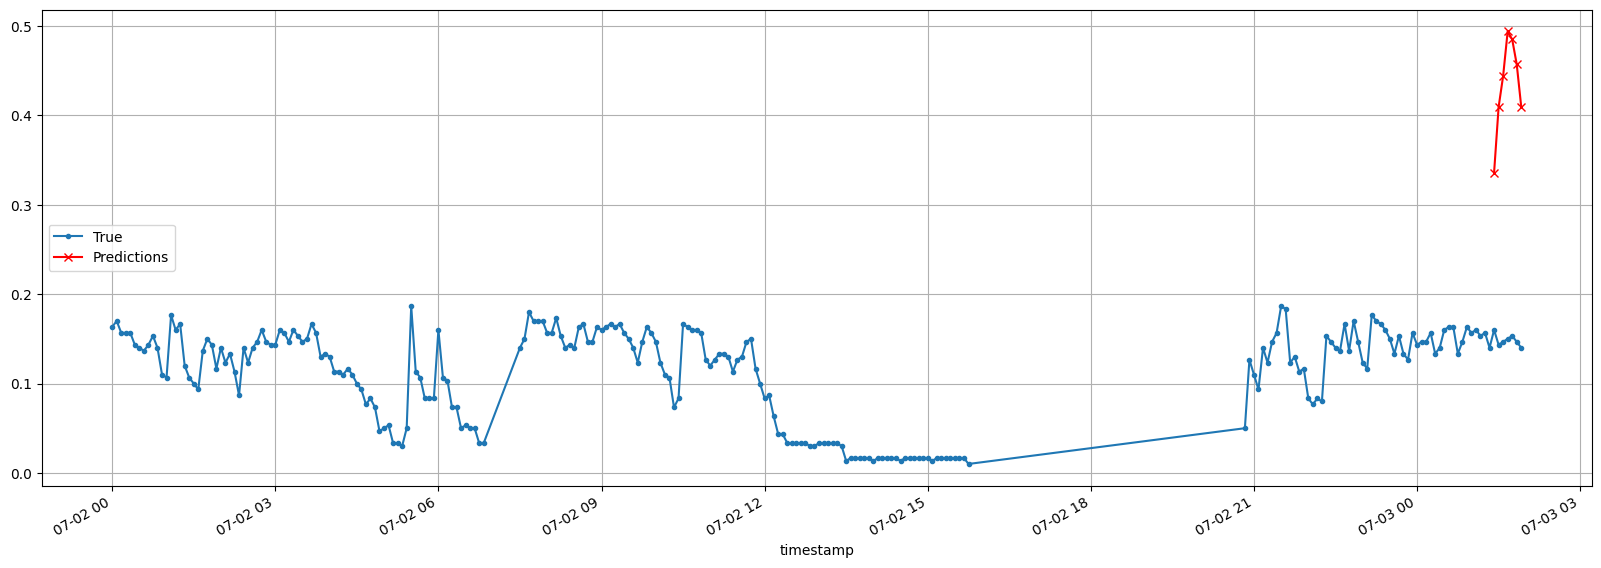

In [109]:
X = test1.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = gru.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts1.index[-sequence_lenght], end=ts1.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts1)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

In [110]:
fit_and_evaluate(gru, seq2seq_train2, seq2seq_valid2)

Epoch 1/10
    588/Unknown 9s 13ms/step - loss: 0.1633 - mae: 0.3006

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


590/590 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.1634 - mae: 0.3008 - val_loss: 0.0377 - val_mae: 0.1485
Epoch 2/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.1533 - mae: 0.2911 - val_loss: 0.0410 - val_mae: 0.1567
Epoch 3/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.1536 - mae: 0.2896 - val_loss: 0.0418 - val_mae: 0.1537
Epoch 4/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.1513 - mae: 0.2845 - val_loss: 0.0370 - val_mae: 0.1317
Epoch 5/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.1475 - mae: 0.2794 - val_loss: 0.0356 - val_mae: 0.1218
Epoch 6/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.1474 - mae: 0.2793 - val_loss: 0.0323 - val_mae: 0.1057
Epoch 7/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.1465 - mae: 0.2793 - val_loss: 0.0307 - val_mae: 0.0991
Epoch 8/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.1450 - mae: 0.2782 - val_loss: 0.0295 - val_mae: 0.0953
Epoch 9/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - lo

88065.52737951279

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


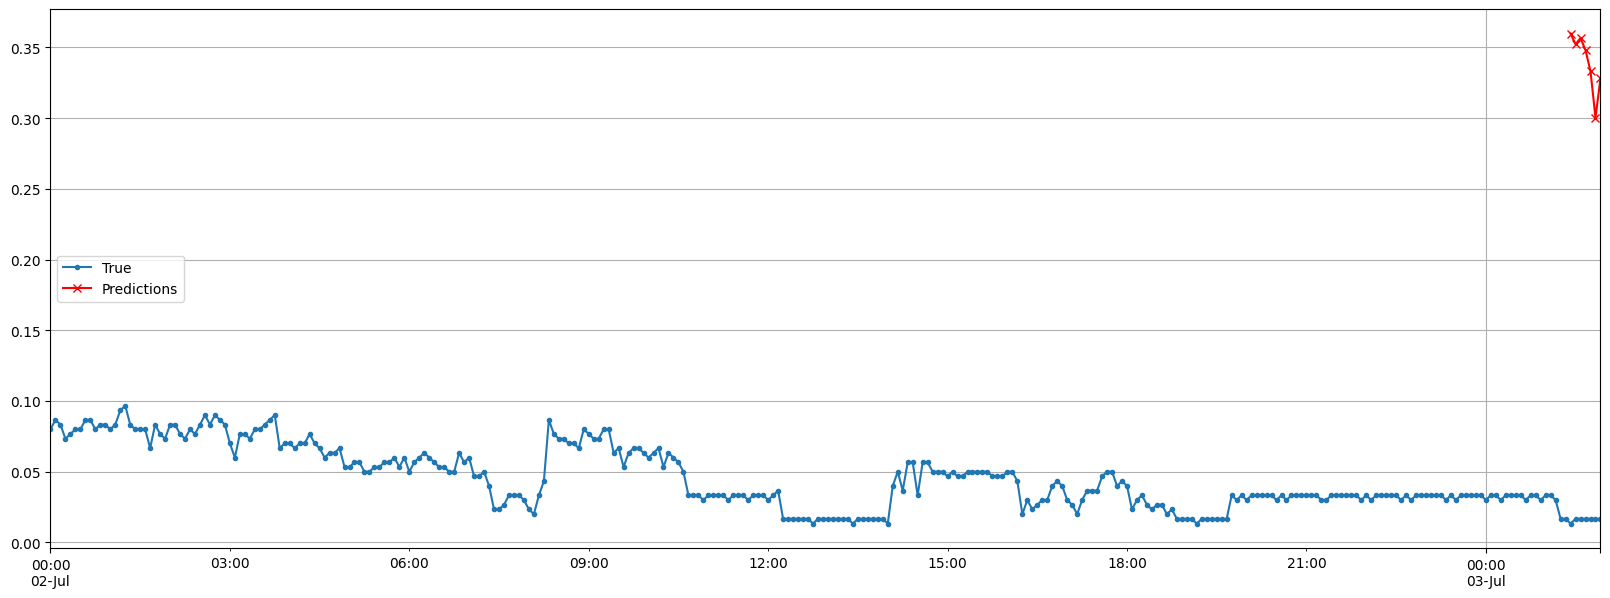

In [111]:
X = test2.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = gru.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts2.index[-sequence_lenght], end=ts2.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts2)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### CNN

In [112]:
seq2seq_cnn_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(neurons*2, return_sequences=True, input_shape=[None, num_features]),
  tf.keras.layers.Conv1D(prediction_lenght, kernel_size=1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [113]:
fit_and_evaluate(seq2seq_cnn_model, seq2seq_train1, seq2seq_valid1)

Epoch 1/10
    697/Unknown 9s 11ms/step - loss: 0.3599 - mae: 0.6958

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


703/703 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.3593 - mae: 0.6951 - val_loss: 0.1866 - val_mae: 0.4398
Epoch 2/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.3426 - mae: 0.6694 - val_loss: 0.1860 - val_mae: 0.4369
Epoch 3/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.3425 - mae: 0.6684 - val_loss: 0.1859 - val_mae: 0.4369
Epoch 4/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.3403 - mae: 0.6659 - val_loss: 0.1858 - val_mae: 0.4364
Epoch 5/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.3410 - mae: 0.6667 - val_loss: 0.1856 - val_mae: 0.4351
Epoch 6/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.3412 - mae: 0.6667 - val_loss: 0.1854 - val_mae: 0.4364
Epoch 7/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.3402 - mae: 0.6654 - val_loss: 0.1854 - val_mae: 0.4361
Epoch 8/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.3392 - mae: 0.6639 - val_loss: 0.1852 - val_mae: 0.4355
Epoch 9/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - los

432016.84951782227

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


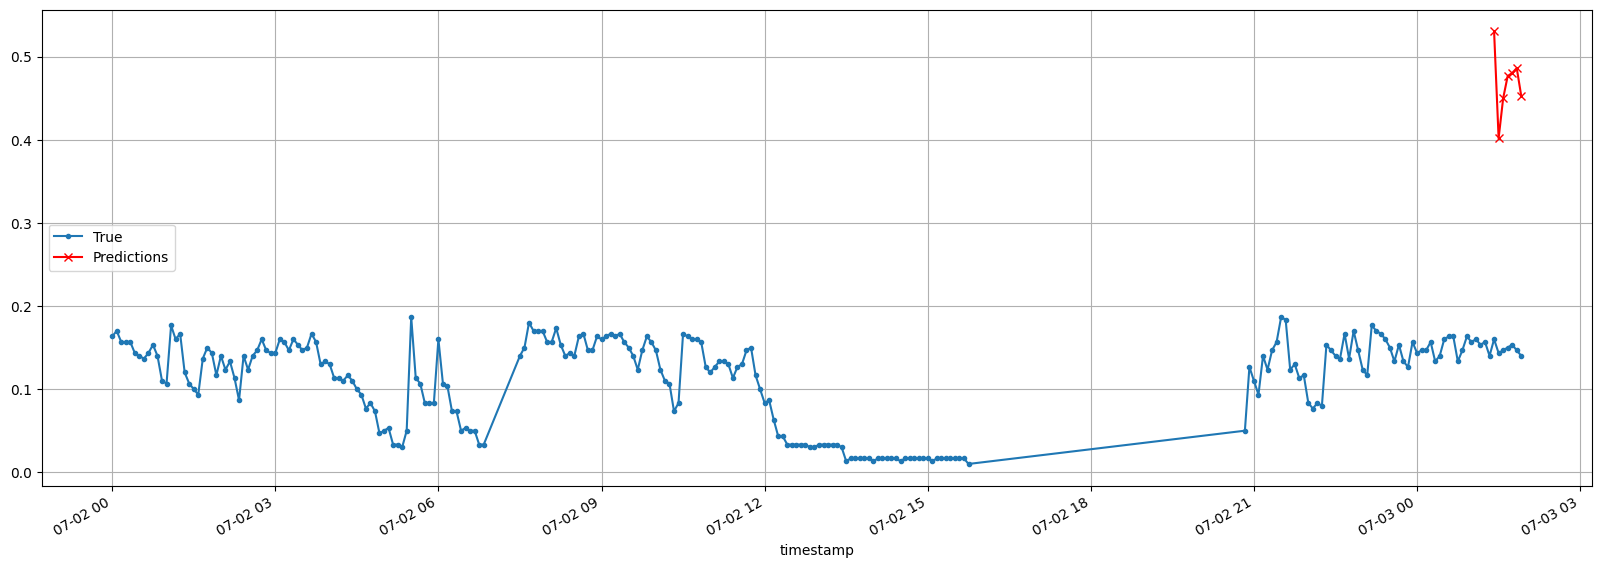

In [114]:
X = test1.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = seq2seq_cnn_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts1.index[-sequence_lenght], end=ts1.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts1)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

In [115]:
fit_and_evaluate(seq2seq_cnn_model, seq2seq_train2, seq2seq_valid2)

Epoch 1/10
    580/Unknown 7s 10ms/step - loss: 0.1644 - mae: 0.3029

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.1648 - mae: 0.3035 - val_loss: 0.0393 - val_mae: 0.1357
Epoch 2/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.1515 - mae: 0.2932 - val_loss: 0.0460 - val_mae: 0.1657
Epoch 3/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.1484 - mae: 0.2882 - val_loss: 0.0421 - val_mae: 0.1478
Epoch 4/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.1457 - mae: 0.2832 - val_loss: 0.0407 - val_mae: 0.1374
Epoch 5/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.1442 - mae: 0.2801 - val_loss: 0.0488 - val_mae: 0.1587
Epoch 6/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.1443 - mae: 0.2799 - val_loss: 0.0368 - val_mae: 0.1210
Epoch 7/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.1422 - mae: 0.2752 - val_loss: 0.0380 - val_mae: 0.1276
Epoch 8/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.1426 - mae: 0.2752 - val_loss: 0.0333 - val_mae: 0.1115
Epoch 9/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - lo

105556.37627840042

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


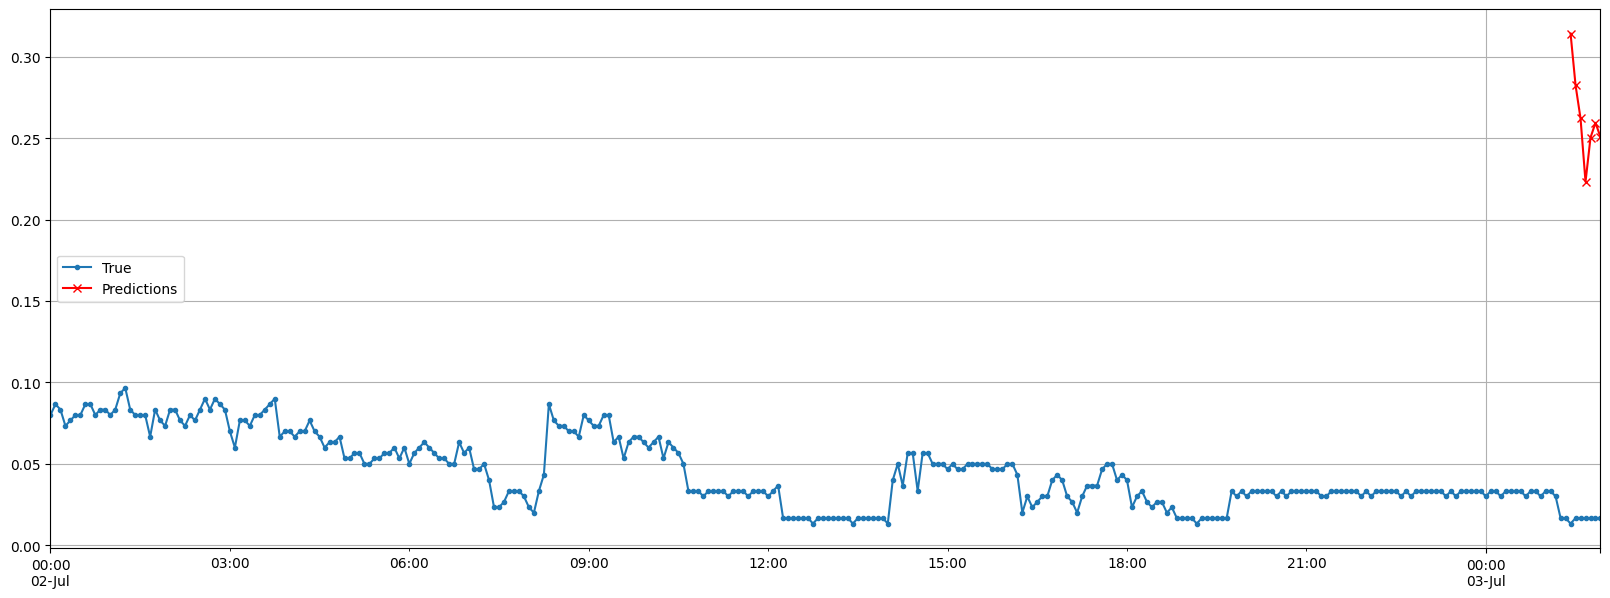

In [116]:
X = test2.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = seq2seq_cnn_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts2.index[-sequence_lenght], end=ts2.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts2)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

LSTM and GRU cells are one of the main reasons behind the success of RNNs.
Yet while they can tackle much longer sequences than simple RNNs, they still
have a fairly limited short-term memory, and they have a hard time learning
long-term patterns in sequences of 100 time steps or more, such as audio
samples, long time series, or long sentences. One way to solve this is to shorten
the input sequences; for example, using 1D convolutional layers.

In [117]:
stride = 2
k_size = 4

conv_rnn_model = tf.keras.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=k_size, strides=stride, activation="relu", input_shape=[None, num_features]),
  tf.keras.layers.GRU(batch_size, return_sequences=True),
  tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [118]:
# ENDPOINT 1:
longer_train1 = to_seq2seq_dataset(train1, seq_length=sequence_lenght*2, shuffle=True, seed=42)
longer_valid1 = to_seq2seq_dataset(valid1, seq_length=sequence_lenght*2)
longer_test1 = to_seq2seq_dataset(test1, seq_length=sequence_lenght*2)
downsampled_train1 = longer_train1.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))
downsampled_valid1 = longer_valid1.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))
downsampled_test1 = longer_test1.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))

In [119]:
fit_and_evaluate(conv_rnn_model, downsampled_train1, downsampled_valid1)

Epoch 1/10
    703/Unknown 10s 12ms/step - loss: 0.3547 - mae: 0.7005

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


703/703 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.3546 - mae: 0.7004 - val_loss: 0.1840 - val_mae: 0.4242
Epoch 2/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - loss: 0.3342 - mae: 0.6584 - val_loss: 0.1830 - val_mae: 0.4211
Epoch 3/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 0.3323 - mae: 0.6556 - val_loss: 0.1822 - val_mae: 0.4203
Epoch 4/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.3316 - mae: 0.6542 - val_loss: 0.1817 - val_mae: 0.4185
Epoch 5/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - loss: 0.3307 - mae: 0.6530 - val_loss: 0.1813 - val_mae: 0.4171
Epoch 6/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.3297 - mae: 0.6518 - val_loss: 0.1809 - val_mae: 0.4172
Epoch 7/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 0.3293 - mae: 0.6512 - val_loss: 0.1806 - val_mae: 0.4157
Epoch 8/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 0.3284 - mae: 0.6498 - val_loss: 0.1803 - val_mae: 0.4152
Epoch 9/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/ste

412079.98991012573

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


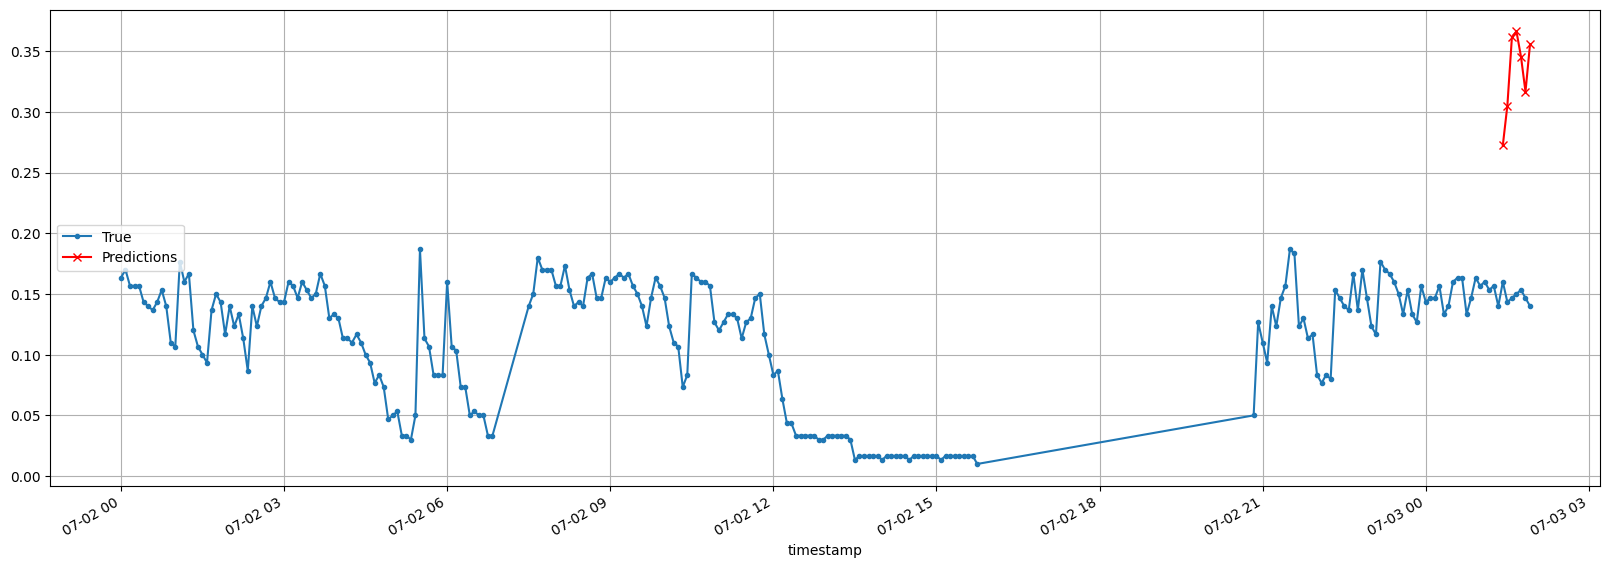

In [120]:
X = test1.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = conv_rnn_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts1.index[-sequence_lenght], end=ts1.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts1)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

In [121]:
# ENDPOINT 2:
longer_train2 = to_seq2seq_dataset(train2, seq_length=sequence_lenght*2, shuffle=True, seed=42)
longer_valid2 = to_seq2seq_dataset(valid2, seq_length=sequence_lenght*2)
longer_test2 = to_seq2seq_dataset(test2, seq_length=sequence_lenght*2)
downsampled_train2 = longer_train2.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))
downsampled_valid2 = longer_valid2.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))
downsampled_test2 = longer_test2.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))

In [122]:
fit_and_evaluate(conv_rnn_model, downsampled_train2, downsampled_valid2)

Epoch 1/10
    583/Unknown 11s 15ms/step - loss: 0.1506 - mae: 0.2882

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


590/590 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - loss: 0.1508 - mae: 0.2885 - val_loss: 0.0438 - val_mae: 0.1485
Epoch 2/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.1408 - mae: 0.2808 - val_loss: 0.0523 - val_mae: 0.1604
Epoch 3/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.1395 - mae: 0.2759 - val_loss: 0.0546 - val_mae: 0.1603
Epoch 4/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.1397 - mae: 0.2765 - val_loss: 0.0498 - val_mae: 0.1475
Epoch 5/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.1368 - mae: 0.2728 - val_loss: 0.0411 - val_mae: 0.1261
Epoch 6/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.1392 - mae: 0.2742 - val_loss: 0.0375 - val_mae: 0.1177
Epoch 7/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.1366 - mae: 0.2703 - val_loss: 0.0357 - val_mae: 0.1129
Epoch 8/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.1375 - mae: 0.2710 - val_loss: 0.0348 - val_mae: 0.1102
Epoch 9/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step 

104191.19894504547

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


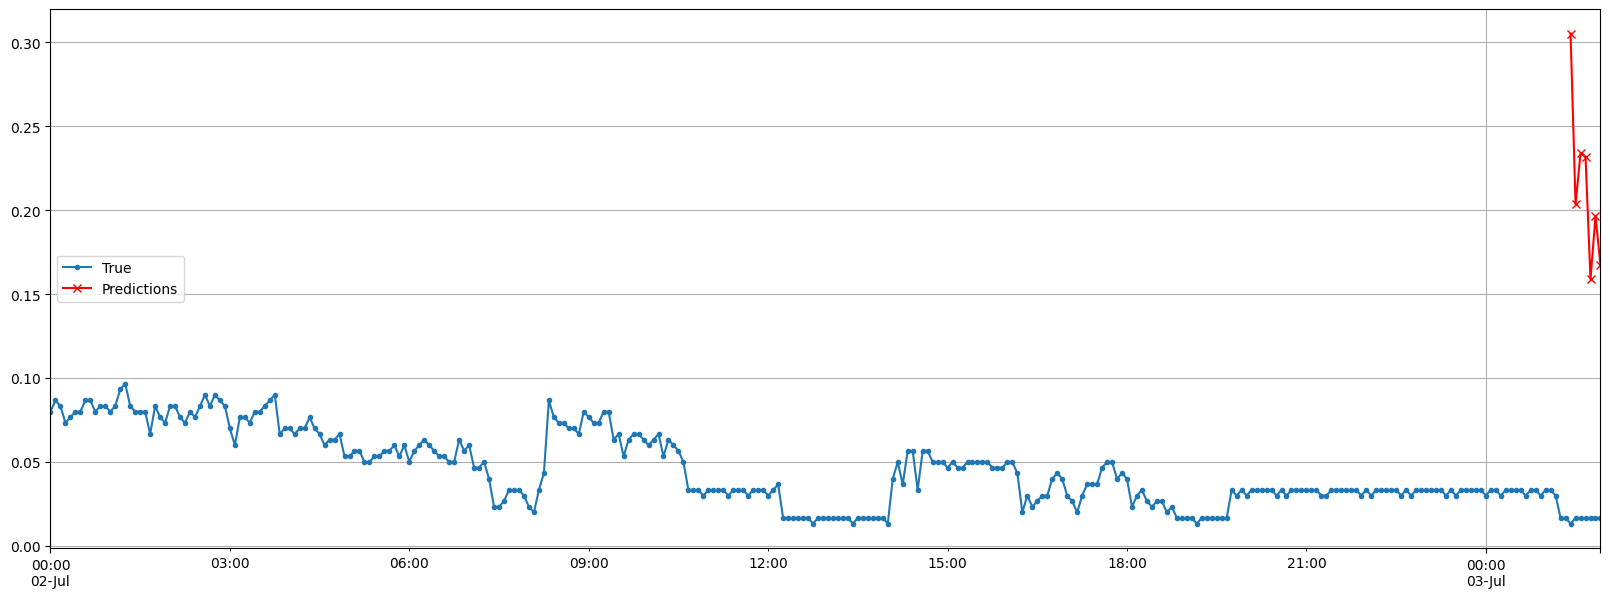

In [123]:
X = test2.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = conv_rnn_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts2.index[-sequence_lenght], end=ts2.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts2)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

## ARMA family



In [124]:
from statsmodels.tsa.arima.model import ARIMA

Check for stationarity with the Augmented Dickey-Fuller test

In [125]:
from statsmodels.tsa.stattools import adfuller

print("Endpoint 1:")
result1 = adfuller(train1['avg_invocations_rate'])
print('ADF Statistic:', result1[0])
print('p-value:', result1[1])
print("Endpoint 2:")
result2 = adfuller(train2['avg_invocations_rate'])
print('ADF Statistic:', result2[0])
print('p-value:', result2[1])

Endpoint 1:
ADF Statistic: -12.170960005983266
p-value: 1.4211817431425884e-22
Endpoint 2:
ADF Statistic: -9.579642062045842
p-value: 2.175838371317368e-16


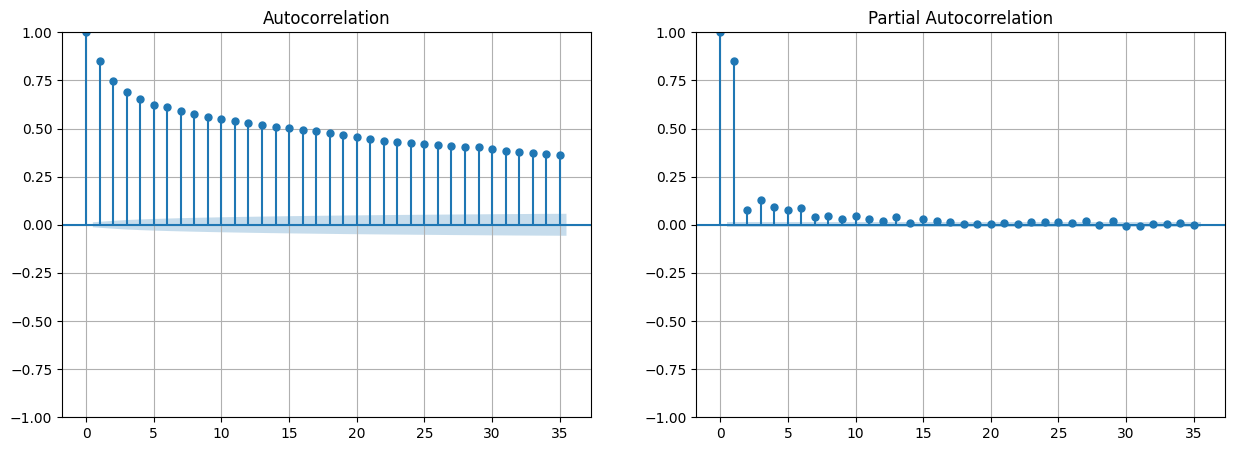

In [126]:
# extra code – shows how to plot the Autocorrelation Function (ACF) and the
#              Partial Autocorrelation Function (PACF)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(train1['avg_invocations_rate'], ax=axs[0], lags=35)
axs[0].grid()
plot_pacf(train1['avg_invocations_rate'], ax=axs[1], lags=35, method="ywm")
axs[1].grid()
plt.show()

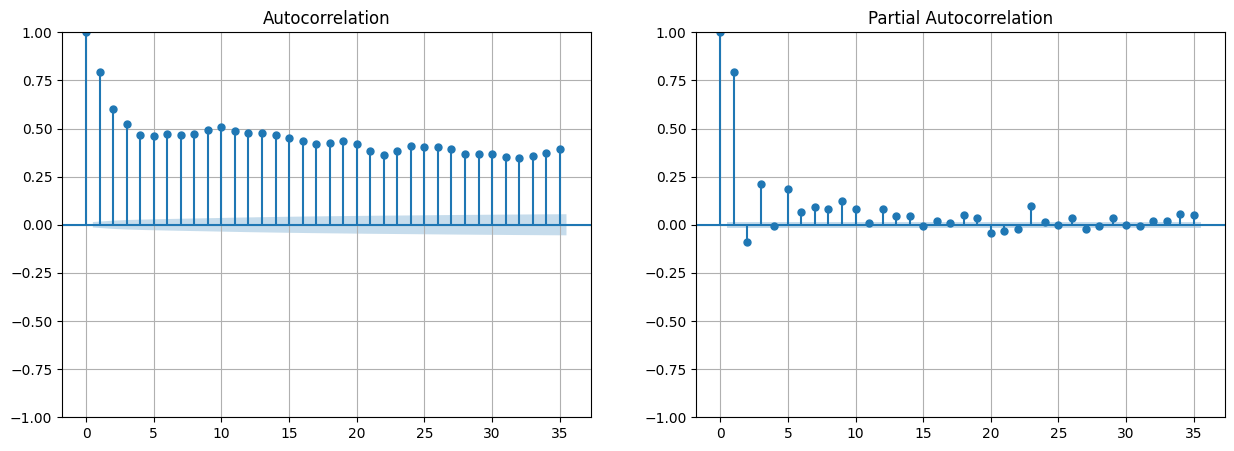

In [127]:
# extra code – shows how to plot the Autocorrelation Function (ACF) and the
#              Partial Autocorrelation Function (PACF)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(train2['avg_invocations_rate'], ax=axs[0], lags=35)
axs[0].grid()
plot_pacf(train2['avg_invocations_rate'], ax=axs[1], lags=35, method="ywm")
axs[1].grid()
plt.show()

order=(p, d, q):
* p = the past p values of the time series, "how far back into the past the model should look";
* d = *order of integration*, running d consecutive rounds of differencing computes an approximation of the dth order derivative of the time series, so it will eliminate polynomial trends up to degree d.
* q = the past q forecast errors ε(t);

seasonal_order=(P, D, Q, s)
* P = , D = , Q =  : to model the time series at  (t–s), (t–2s), (t–3s);
* s = the period of the seasonal pattern.


In [128]:
trimmed_valid1 = ts1.iloc[:-prediction_lenght]
# in realtà dal test risulta stazionaria, ma le performance sembrano migliori
arima = ARIMA(trimmed_valid1, order=(1,1,1))
arima = arima.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


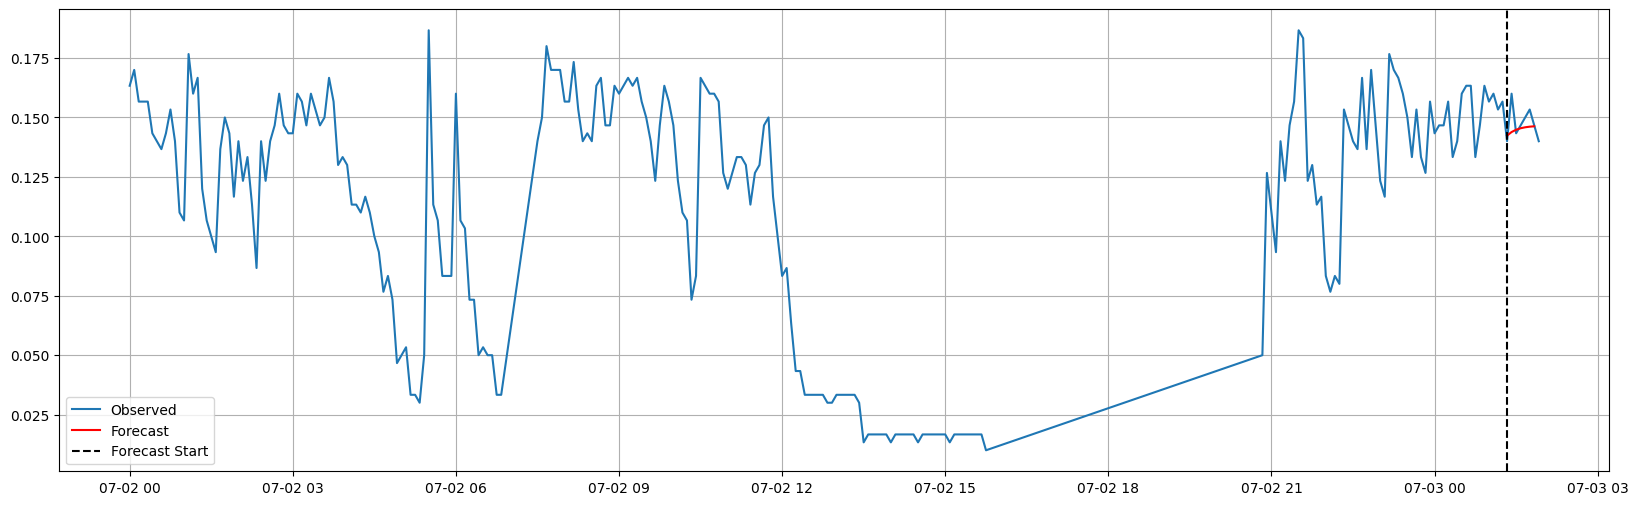

In [129]:
# Forecasting
forecast1 = arima.forecast(steps=prediction_lenght)

plt.figure(figsize=(20, 6))
# Plot the forecast
# original data: full length
plt.plot(ts1.index, ts1, label='Observed')
plt.plot(pd.date_range(trimmed_valid1.index[-1], periods=prediction_lenght, freq=freq), forecast1, label='Forecast', color='red')
plt.axvline(trimmed_valid1.index[-1], linestyle='--', color='black', label='Forecast Start')
plt.legend()
plt.grid()
plt.show()

In [130]:
trimmed_valid2 = ts2.iloc[:-prediction_lenght]
# in realtà dal test risulta stazionaria, ma le performance sembrano migliori
arima = ARIMA(trimmed_valid2, order=(1,1,1))
arima = arima.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


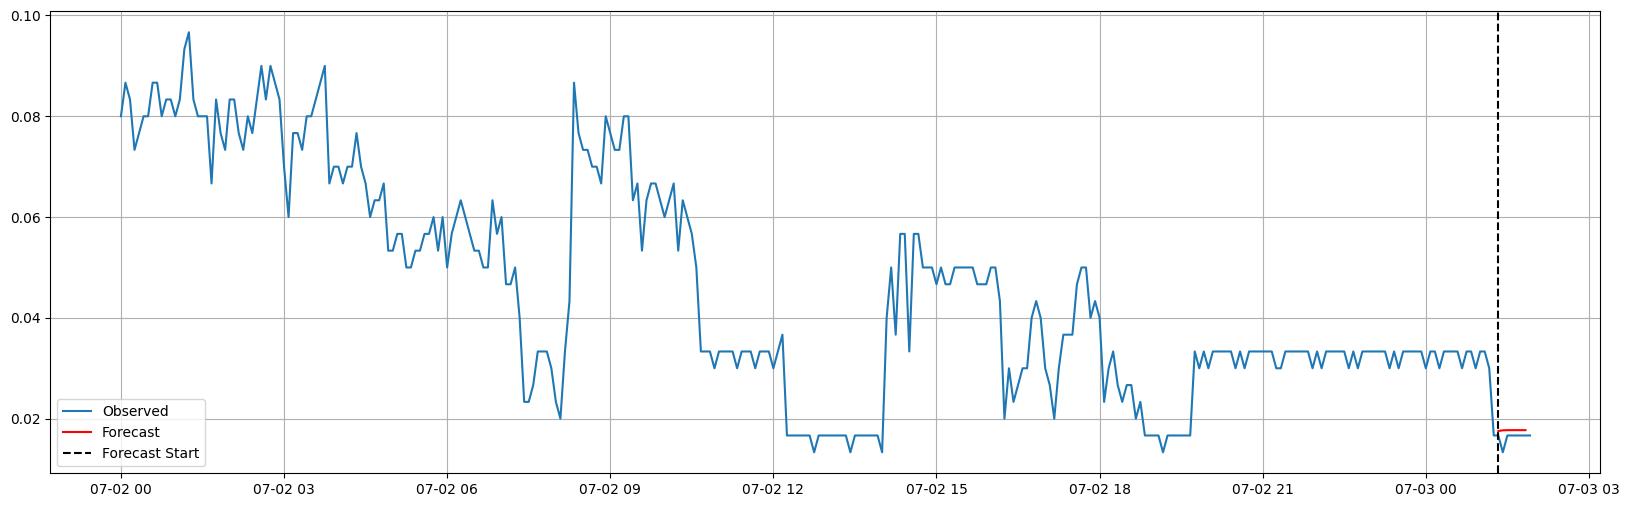

In [131]:
# Forecasting
forecast2 = arima.forecast(steps=prediction_lenght)

plt.figure(figsize=(20, 6))
# Plot the forecast
# original data: full length
plt.plot(ts2.index, ts2, label='Observed')
plt.plot(pd.date_range(trimmed_valid2.index[-1], periods=prediction_lenght, freq=freq), forecast2, label='Forecast', color='red')
plt.axvline(trimmed_valid2.index[-1], linestyle='--', color='black', label='Forecast Start')
plt.legend()
plt.grid()
plt.show()

In [132]:
print(forecast1)

238    0.142353
239    0.143864
240    0.144836
241    0.145460
242    0.145861
243    0.146119
244    0.146284
Name: predicted_mean, dtype: float64
